This notebook contains my solution for the two problems presented:
1. We have synthesized an image-classification problem for you. Your goal is to build a classifier that can detect the class of an input image. 
We have collected images-data from different sources and combine them into this 1 file: gen_img_data.json.zip. Data is well-formatted and if analyzed carefully can help you fully grasp the problem.
2. The Astrological department believes that a person Star can be guessed from its behavior. An organization is collecting blog-posts of different people from various sources. You have been tasked to build a Deep Learning model that can use these posts data of individuals to predict which star group out of 12 does an individual belong to. You also need to tell the gender of that person.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,Activation,Input
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau,CSVLogger,ModelCheckpoint,EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from skimage.color import gray2rgb,rgb2gray
from skimage.transform import resize
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import matplotlib.patches as mpatches
import os
import pickle
import json
import math
from glob import glob
import re

In [0]:
# Setting seed to reproduce results
SEED = 24

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# base_dir = ''

# Image Classification

### Parsing Data
We will start off by parsing and exploring the provided dataset.

In [0]:
def read_json(path):
    with open(path,'r') as f:
        json_obj = json.load(f)
    return json_obj

In [0]:
json_obj = read_json(image_data_path)

In [0]:
len(json_obj)

23702

Let's explore the dataset and see how it is structured

In [0]:
# json_obj[0]

In [0]:
len(json_obj[0]['Ankle boot']['grey'])

784

In [0]:
# json_obj[-1]

In [0]:
len(json_obj[-1]['truck'])

3

In [0]:
json_obj[-1]['truck'].keys()

dict_keys(['R', 'G', 'B'])

From the first glance, I observe two structural properties:
1. There are two types of keys. The outer key is the class name and the inner keys represent the channel
2. The image pixels are located in the nested dictionary object as a vector. This vectors can be reshaped to form images as their lengths are perfect squares

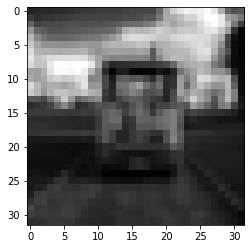

In [0]:
vector_len = len(json_obj[-1]['truck']['R'])
img_dim = [int(math.sqrt(vector_len))] * 2
## Change 'R' to 'G' or 'B' to see other values
img = np.array(json_obj[-1]['truck']['R']).astype('uint8')
plt.imshow(img.reshape(*img_dim),cmap='gray')

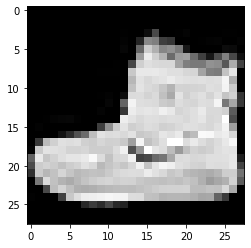

In [0]:
vector_len = len(json_obj[0]['Ankle boot']['grey'])
img_dim = [int(math.sqrt(vector_len))] * 2
img = np.array(json_obj[0]['Ankle boot']['grey']).astype('uint8')
plt.imshow(img.reshape(*img_dim),cmap='gray')

Although my assumption for the aforementioned two structural properties seems valid let's get an overview of the entire dataset keys to confirm the structure

In [0]:
outer_keys = [list(obj.keys())[0] for obj in json_obj]

In [0]:
# outer_keys

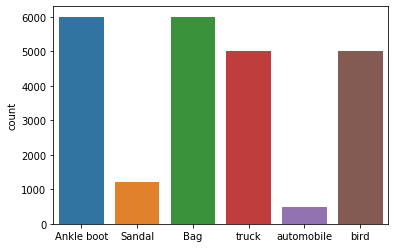

In [0]:
sns.countplot(x=outer_keys)

In [0]:
inner_keys = [''.join(list(list(obj.values())[0].keys())) for obj in json_obj]

In [0]:
# inner_keys

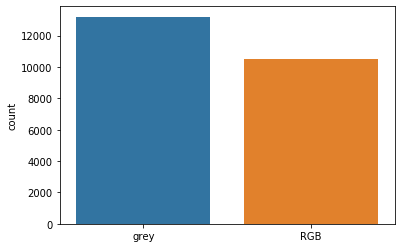

In [0]:
sns.countplot(x=inner_keys)

Through these countplots, we can confirm that the outer key is indeed the class of the image and the inner key represents the channel, the inner key will contain a 1D vector that represents the pixel values for an image. We will now move on to parse this data assuming this structure.

In [0]:
def parse_json(json_objs,color_mode='RGB'):
    # classes = [list(obj.keys())[0] for obj in json_obj]
    classes = []
    imgs = []
    output_dim = (32,32)
    
    for obj in json_objs:
        for k,v in obj.items():
            img_obj = obj[k]
            classes.append(k)
            if len(img_obj.keys()) == 1:
                # Grayscale image
                img_vec = img_obj['grey']
                img_dims = [int(math.sqrt(len(img_vec)))] * 2
                img = np.array(img_vec).astype('uint8').reshape(*img_dims)
                img = resize(img,output_dim)
                if color_mode != 'grayscale':
                    # Convert img to RGB
                    img = gray2rgb(img)
                else:
                    img = np.expand_dims(img,axis=-1)
                imgs.append(img)
            else:
                # RGB image
                img_dims = [int(math.sqrt(len(img_obj['R'])))] * 2
                R = np.array(img_obj['R']).astype('uint8').reshape(*img_dims)
                G = np.array(img_obj['G']).astype('uint8').reshape(*img_dims)
                B = np.array(img_obj['B']).astype('uint8').reshape(*img_dims)
                img = np.zeros(img_dims+[3],dtype='uint8')
                img[:,:,0] = R
                img[:,:,1] = G
                img[:,:,2] = B
                img = resize(img,output_dim)
                if color_mode != "RGB":
                    # Convert img to grayscale
                    img = rgb2gray(img)
                    img = np.expand_dims(img,axis=-1)
                imgs.append(img)
    return classes,np.asarray(imgs)

In [0]:
classes,rgb_imgs = parse_json(json_obj,color_mode='RGB')
_,gray_imgs = parse_json(json_obj,color_mode='grayscale')

In [0]:
# Making sure the number of data points is correct
len(classes) == len(rgb_imgs) == len(gray_imgs)

True

Let's print out some images and their corresponding images to make sure the parsing was correct

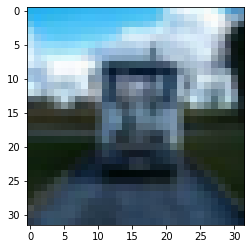

In [0]:
plt.imshow(imgs[-1])

In [0]:
classes[-1]

'truck'

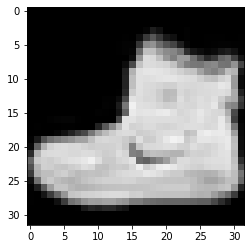

In [0]:
plt.imshow(imgs[0])

In [0]:
classes[0]

'Ankle boot'

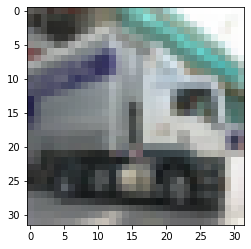

In [0]:
plt.imshow(imgs[-2000])

In [0]:
classes[-2000]

'truck'

Let's assign numeric labels to these string values, and then onehot encode them. We could use a loss like 'sparse_categorical_crossentropy' with int labels, but to stick to standard practices, let's one-hot encode them nevertheless.

In [0]:
def onehot_encode(string_labels,labels_dict):
    labels = [labels_dict[c] for c in string_labels]
    labels = to_categorical(labels)
    return labels

In [0]:
labels_dict = {k:v for v,k in enumerate(list(sorted(set(classes))))}

In [0]:
labels_dict

{'Ankle boot': 0,
 'Bag': 1,
 'Sandal': 2,
 'automobile': 3,
 'bird': 4,
 'truck': 5}

In [0]:
labels = onehot_encode(classes,labels_dict)

This seems alright. We can move on to pre-processing now

The dataset seems to have two distributions, one is grayscale images from FashionMNIST and the other one is RGB images. We will perform the following pre-processing methods:
- Normalization: It is widely known in practice that normalization of pixel values from [0,255] to [0,1] helps training Neural Networks, so we will apply it.
- Augmentation: In order to generalize our model better and consequently perform better on unseen variations, we will artificially augment data as well dynamically.

We will be using these methods through TensorFlow's ImageDataGenerator object

In [0]:
BATCH_SIZE = 128
EPOCHS = 100
GRAY_IMG_SHAPE = (32,32,1)
RGB_IMG_SHAPE = (32,32,3)
NUM_CLASSES = len(labels_dict)
LABELS_DICT = {v:k for k,v in labels_dict.items()}

The following function will split our data into a train and validation set (Which will be used for model selection) and return generators to train our models. The train_test_split will also shuffle the data.

In [0]:
def get_generators(imgs,labels,test=False):
    if not test:
        x_train,x_val,y_train,y_val = train_test_split(imgs,labels,test_size=0.2,random_state=SEED)
        train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=45,
                                 width_shift_range=.15,
                                 height_shift_range=.15,
                                 horizontal_flip=True,
                                 zoom_range=0.2,
                                 validation_split=0.2,
                                )
        val_datagen = ImageDataGenerator(rescale=1./255)
        train_gen = train_datagen.flow(x_train,y_train,batch_size=BATCH_SIZE,seed=SEED)
        val_gen = val_datagen.flow(x_val,y_val,batch_size=BATCH_SIZE,shuffle=False)
        return train_gen,val_gen
    else:
        datagen = ImageDataGenerator(rescale=1./255)
        test_gen = datagen.flow(imgs,labels,batch_size=BATCH_SIZE,shuffle=False)
        return test_gen

### Model Design
Since we are dealing with two types of images, we will need to map one format on to the other. We have two options:
1. Map Grayscale to RGB
2. Convert RGB to Grayscale

<br>

We will explore both these options and then carry forward the model that performs better for further improvements and analysis

We have options for our choice of model as well. Since we are dealing with images then it makes obvious sense to use convolutional neural networks in order to leverage learning kernels that will represent characteristic features of images. Within CNNs, we have two options:
1. Fine-tune a pre-trained network like VGG16, ResNet50, etc.
2. Design a neural network and train it from scratch

Using the above options for choice of model and input image format, we end up with 3 feasible options:

1. Train a custom model from scratch on Grayscale images.
2. Train a custom model from scratch on RGB images.
3. Fine-tune a pre-trained model on RGB images (RGB only since these models are not trained on grayscale images)

We will start off by designing a CNN model that classifies images in our dataset. The design will be motivated by a few factors observed in the dataset:

1. The network doesn't necessarily has to be very deep in terms of layers (Like ResNet50) or have millions of parameters. The reason is because our image size is small, so a reasonable amount of filters should be able to extract representative image features. Another reason is that the problem at hand is relatively small i.e. we have to classify images of 6 different classes only.

2. Although the above statement may seem to suggest that the problem is easy, this is not the case as the dataset contains images essentially from two different distributions. We have RGB images vs Grayscale images and also 3 classes are from FashionMNIST representing clothing items, while the other 3 are from another imagenet like dataset. A really simple naive CNN would not really be a good start although one can build incrementally but that might waste resources and time.


Furthermore, we will also incorporate common design choices made by practionioners that have usually always worked out. These choices include:

1. Using ReLu activation in Conv Layers: Apart from adding non-linearity, ReLu will also "deactivate" some neurons where the output is less than 0. This is computationally effecient compared to other activations. It has been widely recommended as well.

2. Keeping small odd kernel sizes: Keeping small kernel sizes will allow us to learn more local features and the odd size will keep convolutions symmetrical. Smaller sizes make more sense here since our data consists of very small images.

3. Using Pooling: Pooling allows us to downsample our latent space and reduces computations as well. We can use MaxPooling to learn low-level features and AvgPooling to learn smooth features. In this matter we can explore 3 options: 1) Use one kind of pooling, 2) Use a mix of both pooling, 3) Use strided convolutions to downsample. In our case we will opt for MaxPooling for now, since we need to detect objects within an image so we need to learn low-level sharp features.

4. Use BatchNorm: Just like normalizing inputs to the Model, normalizing the inputs to layers also has benefits. BatchNorm has been known for speeding up training, add a regularizing effect, among other reasons as well. The general consensus is to use BatchNorm afte the convolulational layer and before the activation layer, but I read a comment by Francois Chollet that it should be used after relu.


5. Use Dropout: In order to prevent our model from overfitting the data we will add dropout layers that will prevent neurons from depending on each other. This will regularize our model and make it robust to variations in data.

Apart from these, the hyperparameters used will be somewhat arbitrary and will be tweaked if need be.

In [0]:
def classification_model(input_shape,opt,num_classes=6):
    model = Sequential()
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(opt,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

We will also define our VGG16 model here. Here we will add a few fully connected layers to fine tune the model. In addition to this, we will set the last convolutional block to trainable as well to learn some high level features

In [0]:
def vgg_classification_model(base_model,opt,num_classes=6):
    flat = Flatten()(base_model.layers[-1].output)
    dense = Dense(1024,activation='relu')(flat)
    bnorm = BatchNormalization()(dense)
    dense = Dense(128,activation='relu')(bnorm)
    drop = Dropout(0.25)(dense)
    prediction = Dense(num_classes,activation='softmax')(drop)
    model = Model(base_model.layers[0].input,prediction)
    for layer in model.layers[:25]:
        layer.trainable = False
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

We will create instances of all models here. For all models we will use the Adam optimizer since it has worked almost always in my experience. We will use the default learning rate of 0.001 and beta_1 value of 0.5. I read somewhere that lower beta_1 values improve convergence so I have usually used 0.5 as a starting point instead of the default

In [0]:
# base_model = VGG16(include_top=False, weights='imagenet',input_shape=RGB_IMG_SHAPE)
gray_custom_opt = Adam(learning_rate=0.001,beta_1=0.5)
rgb_custom_opt = Adam(learning_rate=0.001,beta_1=0.5)
# rgb_vgg_opt = Adam(learning_rate=0.001,beta_1=0.5)
gray_custom_model = classification_model(GRAY_IMG_SHAPE,gray_custom_opt,num_classes=NUM_CLASSES)
rgb_custom_model = classification_model(RGB_IMG_SHAPE,rgb_custom_opt,num_classes=NUM_CLASSES)
# rgb_vgg16_model = vgg_classification_model(base_model,rgb_vgg_opt,num_classes=NUM_CLASSES)

In [0]:
# rgb_model.summary()

Before training, let us recall the class distribution countplot. The plot clearly shows a significant class imbalance, where "Sandal" and "automobile" classes are much much fewer than the other classes. This needs to be addressed while training our model because otherwise our model's accuracy/loss will be heavily influenced by the samples which have more samples. To try to resolve this, we will use a weighted loss (Weighted Cross-Entropy) which will assign more weight to those classes that have fewer samples. To calculate these class weights we will use Sci-kit Learn's compute_class_weight function and we would want 'balanced' weights.

In [0]:
int_labels = [labels_dict[c] for c in classes]
class_weights = compute_class_weight(class_weight='balanced',classes=list(LABELS_DICT.keys()),y=int_labels)

In [0]:
class_weights = { k:v for k,v in enumerate(list(class_weights))}

In [0]:
class_weights

{0: 0.6583888888888889,
 1: 0.6583888888888889,
 2: 3.289203441576464,
 3: 7.884896872920825,
 4: 0.7900666666666667,
 5: 0.7900666666666667}

We will also use callbacks that have been provided in the TensorFlow Keras API. These callbacks will help us during model training. We will be making use of:

1. ModelCheckpoint: This is essential since it allows training your model in intervals and will also keep track of the best models when passed save_best_only=True

2. CSVLogger: This will maintain a log of our model training

3. reduceLR: This will help if our model gets "stuck" and will dynamically change our learning rate.

Another good callback is of Tensorboard that allows us to debug our model and monitor it in real-time. But It doesn't seem at this point that our model is complex enough to run into potential issues.

In [0]:
def get_callbacks(model_name):
    chkpt = ModelCheckpoint(base_dir+f'Models/{model_name}_model/{model_name}_'+'weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True,save_weights_only=True)
    csvLogger = CSVLogger(model_name)
    reduceLR = ReduceLROnPlateau()
    callbacks = [chkpt,csvLogger,reduceLR]
    return callbacks

Let's train our model now with all images converted to a single channel grayscale format

In [0]:
train_gen,val_gen = get_generators(gray_imgs,labels)

In [0]:
callbacks = get_callbacks('gray_model')

In [0]:
gray_custom_hist = gray_custom_model.fit(train_gen,
                               steps_per_epoch=train_gen.n//BATCH_SIZE,
                               validation_data=val_gen,
                               validation_steps=val_gen.n//BATCH_SIZE,
                               callbacks=callbacks,
                         epochs=EPOCHS,
                        class_weight=class_weights
                              )

Epoch 1/100
148/148 [==============================] - 8s 57ms/step - loss: 1.2781 - accuracy: 0.5416 - val_loss: 5.3924 - val_accuracy: 0.2023 - lr: 0.0010
Epoch 2/100
148/148 [==============================] - 7s 50ms/step - loss: 0.8343 - accuracy: 0.6783 - val_loss: 7.2514 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 3/100
148/148 [==============================] - 8s 52ms/step - loss: 0.7208 - accuracy: 0.7153 - val_loss: 7.4881 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 4/100
148/148 [==============================] - 8s 51ms/step - loss: 0.6590 - accuracy: 0.7448 - val_loss: 5.3106 - val_accuracy: 0.2040 - lr: 0.0010
Epoch 5/100
148/148 [==============================] - 8s 52ms/step - loss: 0.6356 - accuracy: 0.7514 - val_loss: 2.6124 - val_accuracy: 0.4299 - lr: 0.0010
Epoch 6/100
148/148 [==============================] - 8s 51ms/step - loss: 0.5911 - accuracy: 0.7753 - val_loss: 0.9494 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 7/100
148/148 [==============================] - 7s 

We will be saving the history objects as well so we can reuse them for analysis.

In [0]:
def save_history(hist,path):
    with open(path, 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

In [0]:
gray_hist_path = base_dir+'Models/gray_custom_model/history.pkl'
save_history(gray_custom_hist,gray_hist_path)

Let's try RGB images with our custom model now.

In [0]:
train_gen,val_gen = get_generators(rgb_imgs,labels)

In [0]:
callbacks = get_callbacks('rgb_model')

In [0]:
rgb_custom_hist = rgb_custom_model.fit(train_gen,
                               steps_per_epoch=train_gen.n//BATCH_SIZE,
                               validation_data=val_gen,
                               validation_steps=val_gen.n//BATCH_SIZE,
                               callbacks=callbacks,
                               epochs=EPOCHS
                              )

Epoch 1/100
148/148 [==============================] - 11s 76ms/step - loss: 0.9244 - accuracy: 0.6831 - val_loss: 6.4268 - val_accuracy: 0.2023 - lr: 0.0010
Epoch 2/100
148/148 [==============================] - 11s 73ms/step - loss: 0.5290 - accuracy: 0.8128 - val_loss: 7.5065 - val_accuracy: 0.2031 - lr: 0.0010
Epoch 3/100
148/148 [==============================] - 11s 74ms/step - loss: 0.4391 - accuracy: 0.8421 - val_loss: 6.8042 - val_accuracy: 0.2029 - lr: 0.0010
Epoch 4/100
148/148 [==============================] - 11s 74ms/step - loss: 0.3844 - accuracy: 0.8675 - val_loss: 5.6741 - val_accuracy: 0.2061 - lr: 0.0010
Epoch 5/100
148/148 [==============================] - 11s 74ms/step - loss: 0.3620 - accuracy: 0.8755 - val_loss: 0.5793 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 6/100
148/148 [==============================] - 11s 73ms/step - loss: 0.3276 - accuracy: 0.8855 - val_loss: 0.2574 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 7/100
148/148 [==============================]

In [0]:
rgb_hist_path = base_dir+"Models/rgb_custom_model/rgb_custom_history.pkl"
save_history(rgb_custom_hist,rgb_hist_path)

Finally, let's train a VGG16 model on RGB images before we move on to comparison and analysis.

In [0]:
train_gen,val_gen = get_generators(rgb_imgs,labels)

In [0]:
callbacks = get_callbacks('rgb_vgg_model')

In [0]:
rgb_vgg_hist = rgb_vgg16_model.fit(train_gen,
                               steps_per_epoch=train_gen.n//BATCH_SIZE,
                               validation_data=val_gen,
                               validation_steps=val_gen.n//BATCH_SIZE,
                               callbacks=callbacks,
                               epochs=EPOCHS
                              )

Epoch 1/100
148/148 [==============================] - 19s 126ms/step - loss: 1.9774 - accuracy: 0.2316 - val_loss: 1.9539 - val_accuracy: 0.2527 - lr: 0.0010
Epoch 2/100
148/148 [==============================] - 16s 110ms/step - loss: 1.9757 - accuracy: 0.2317 - val_loss: 1.9540 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 3/100
148/148 [==============================] - 16s 110ms/step - loss: 1.9772 - accuracy: 0.2318 - val_loss: 1.9537 - val_accuracy: 0.2530 - lr: 0.0010
Epoch 4/100
148/148 [==============================] - 16s 111ms/step - loss: 1.9725 - accuracy: 0.2300 - val_loss: 1.9539 - val_accuracy: 0.2525 - lr: 0.0010
Epoch 5/100
148/148 [==============================] - 16s 109ms/step - loss: 1.9752 - accuracy: 0.2327 - val_loss: 1.9536 - val_accuracy: 0.2527 - lr: 0.0010
Epoch 6/100
148/148 [==============================] - 17s 113ms/step - loss: 1.9763 - accuracy: 0.2303 - val_loss: 1.9542 - val_accuracy: 0.2525 - lr: 0.0010
Epoch 7/100
148/148 [=========================

In [0]:
vgg_hist_path = base_dir+"Models/rgb_vgg_model/rgbVgg_history.pkl"
save_history(rgb_vgg_hist,vgg_hist_path)

In [0]:
def load_history(path):
    with open(path, 'rb') as file:
        history=pickle.load(file)
    return history

In [0]:
gray_hist_path = base_dir+'Models/gray_custom_model/history.pkl'
rgb_hist_path = base_dir+"Models/rgb_custom_model/rgb_custom_history.pkl"
vgg_hist_path = base_dir+"Models/rgb_vgg_model/rgbVgg_history.pkl"

### Analysis & Model Selection

we'll off by comparing the performance of each model trained. We will look at their loss and accuracy and try to filter out model(s) that did not perform well.

In [0]:
def plotHistories(histories, names, metric,epochs):
    plt.clf() 
    x_axis = list(range(epochs))
    for hist, name in zip(histories, names):
        plt.plot(x_axis, hist[metric], label=metric+'_'+name)
        plt.scatter(x_axis, hist[metric])
    plt.legend()
    m = metric.capitalize()
    plt.xlabel("Epochs")
    plt.ylabel(m)
    plt.title(f"{m} for {','.join(names)}")
    plt.show()

In [0]:
def plotHistory(hist,name,metric,epochs):
    x_axis = list(range(epochs))
    plt.plot(x_axis,hist[metric],label=metric)
    plt.plot(x_axis,hist[f'val_{metric}'],label=f'val_{metric}')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training plot for {name}")

In [0]:
gray_custom_hist = load_history(gray_hist_path)
rgb_custom_hist = load_history(rgb_hist_path)
vgg_model_hist = load_history(vgg_hist_path)

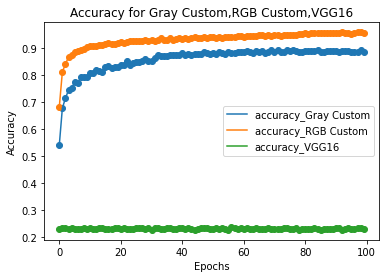

In [0]:
histories = [gray_custom_hist,rgb_custom_hist,vgg_model_hist]
names = ["Gray Custom", "RGB Custom", "VGG16"]
plotHistories(histories,names,'accuracy',EPOCHS)

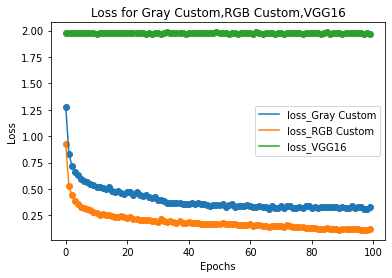

In [0]:
plotHistories(histories,names,'loss',EPOCHS)

From the above plots of Accuracy and Loss, we can clearly observe that the VGG16 Fine-tuned model fails badly on this problem. The custom model on the other hand performs significantly better with both RGB and Grayscale model giving good results. We also note that the RGB model performs the best according to the training accuracy. Normally, we expect pre-trained models like VGG16 to work a lot better due to the learned filters, however it fails for our problem. Potential reasons could be:

1. Grayscale images: Our data contains 3 classes which are grayscale images, even after converting them to RGB images they are still essentially grayscale images and VGG16 has been pretrained on a coloured dataset

2. Image size: Our images are a lot smaller in dimensions that those VGG was trained on, this has an impact on the resubility of the learned filters of VGG16. A potential fix could be to resize our images to match with Imagenet dimensions, but that experiment seems unecessary since our custom model is already giving good results.

3. Frozen weights: Almost all weights have been frozen and this is probably the most important factor because there is a difference between the domain of imagenet and our dataset (FashionMNIST images primarily). Our images lack many high level features like those you would find in say a dataset of animals. Low-level feature detection is crucial since for instance the edges of objects in the FashionMNIST are extremely important in differentiating between classes. Our custom model on the other hand was able to learn low-level features (Initial Conv layers) and high-level features (Later Conv layers) that most probably made it perform better. Another experiment could be to train the VGG16 from scratch or set all layers to trainable but that would be highly expensive in terms of resource consumption. 

Although from the training plots above, we could say that the custom model with RGB images is the best model, but that wouldn't be conclusive becuase we have only evaluated training metrics and not the validation metrics. Let's compare each model's training metrics with the validation metrics and see whether any model has high variance and is overfitting. In this part we will focusing on loss only, the reason being that it is a better metric as it also shows how confident the model was regarding it's prediction.

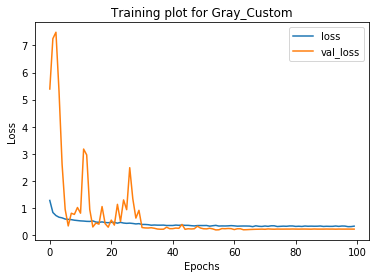

In [0]:
# Gray Custom Model
plotHistory(gray_custom_hist,"Gray_Custom",'loss',EPOCHS)

The model does not seem to overfit and it generalizes well after ~30 epochs, since after that the validation loss becomes stable. The fluctuations in the validation loss can be due to "hard" batches which probably contain the low sample classes. We also notice that the validation loss is lower than the training loss, this is due to the dropout layers we have added, and dropout is serving its purpose well since when all neurons of the model are active, the model performs better which means that each neuron is adding more meaning information. Overall, the training seems to go smooth and our model seems to have generalized well over the problem.

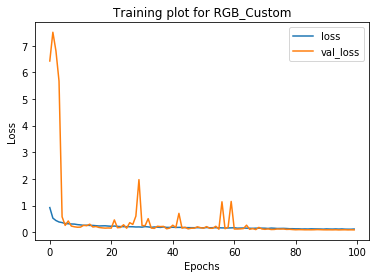

In [0]:
# RGB Custom Model
plotHistory(rgb_custom_hist,"RGB_Custom",'loss',EPOCHS)

The RGB model follows a similar trend, only that it converges and generalizes faster. Again, we observe some spikes in the validation loss due to "bad" batches probably, but other than that the training is smooth. The validation loss is lower that the training loss in this case as well for the exact same reason.

Both model seem to generalize well, and do not overfit. We still need some more fine-grained analysis in order to see which model is performing better. For this, we will compute more metrics and make more visualisations in order to select the best model out of the two.

**Confusion Matrix**<br>
Confusion matrix provides a more deeper insight into our models rather than just plain accuracy/loss. These macro metrics are primarily dominated by classes with higher number of samples, so If our model is performing well on those classes and bad on all others, the overall accuracy will still be high. Confusion matrix will tell us how "confused" our model is between classes and will give us a more realistic picture of what's happening under the hood.

In [0]:
def compute_conf_mat(data_gen,model):
    predictions = model.predict(data_gen)
    y_pred = np.argmax(predictions,axis=1)
    y_true = np.argmax(data_gen.y,axis=1)
    conf_mat = confusion_matrix(y_true=y_true,y_pred=y_pred)
    return conf_mat,y_pred

In [0]:
gray_custom_model.load_weights('Models/gray_custom_model/grayCustom_weights.55-0.19.hdf5')
rgb_custom_model.load_weights('Models/rgb_custom_model/rgbCustom_weights.95-0.09.hdf5')

In [0]:
_,gray_val_gen = get_generators(gray_imgs,labels)
_,rgb_val_gen = get_generators(rgb_imgs,labels)

In [0]:
gray_conf_mat,gray_y_pred = compute_conf_mat(gray_val_gen,gray_custom_model)
rgb_conf_mat,rgb_y_pred = compute_conf_mat(rgb_val_gen,rgb_custom_model)

In [0]:
def plot_confusion_matrix(conf_mat,classes):
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    f = plt.figure(figsize=(8,8))
    sns.set(font_scale=1.4) # for label size
    ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g') # font size
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    return f

In [0]:
classes = sorted(list(labels_dict.keys()))

**Gray**

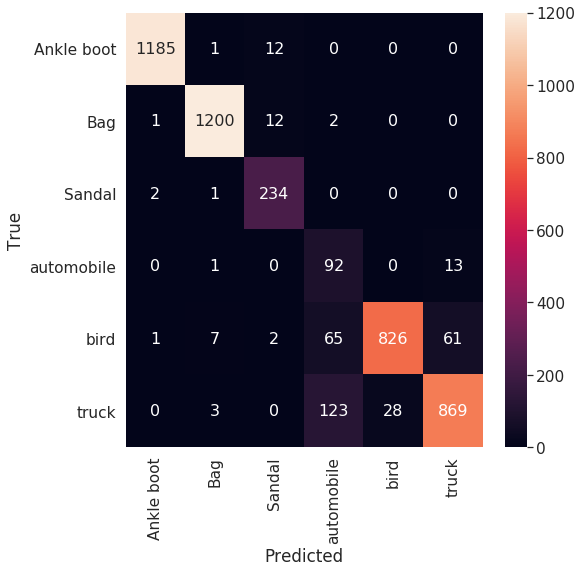

In [0]:
gray_fig = plot_confusion_matrix(gray_conf_mat,classes)

From the first glance we can see that we don't see the ideal case i.e. a perfect diagonal matrix but our model still seems to perform fairly well on all classes. The confusion mainly lies between the RGB images in the dataset. We can summarize the results using sci-kit learn's classification_report

In [0]:
gray_report = classification_report(np.argmax(gray_val_gen.y,axis=1),gray_y_pred,target_names=classes)
print(gray_report)

              precision    recall  f1-score   support

  Ankle boot       1.00      0.99      0.99      1198
         Bag       0.99      0.99      0.99      1215
      Sandal       0.90      0.99      0.94       237
  automobile       0.33      0.87      0.47       106
        bird       0.97      0.86      0.91       962
       truck       0.92      0.85      0.88      1023

    accuracy                           0.93      4741
   macro avg       0.85      0.92      0.87      4741
weighted avg       0.95      0.93      0.94      4741



Overall, our model has high precision and comparable high recall which is a good thing. The model however gets confused when it comes to automobile and incorrectly classifies other classes as automobile as shown by the low precision. It does have a high recall though, which means that 87% of the actual automobile classes were correctly classified. Consequently, we can see that the class of automobile has affected the recall of bird and truck class. The model has an accuracy of 94% on the validation set. We will use weighted average since we want to account for the class imbalance to give a more realistic measure of the performance.

**RGB**

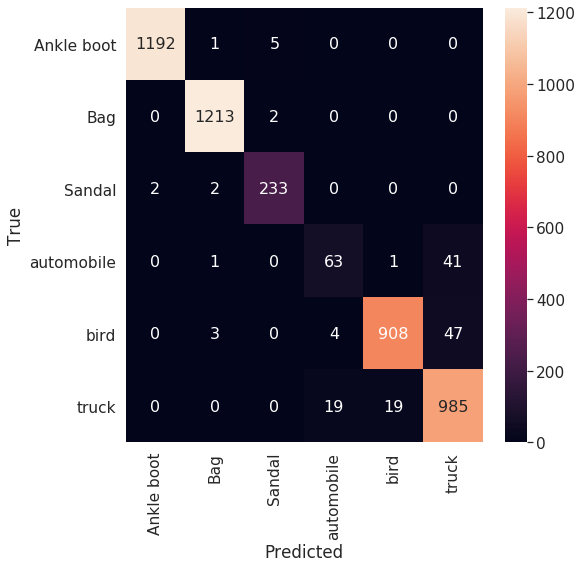

In [0]:
rgb_fig = plot_confusion_matrix(rgb_conf_mat,classes)

We see similar trends for the RGB model as well, although it is performing slightly better. Let's generate its classification report as well

In [0]:
rgb_report = classification_report(np.argmax(rgb_val_gen.y,axis=1),rgb_y_pred,target_names=classes)
print(rgb_report)

              precision    recall  f1-score   support

  Ankle boot       1.00      0.99      1.00      1198
         Bag       0.99      1.00      1.00      1215
      Sandal       0.97      0.98      0.98       237
  automobile       0.73      0.59      0.66       106
        bird       0.98      0.94      0.96       962
       truck       0.92      0.96      0.94      1023

    accuracy                           0.97      4741
   macro avg       0.93      0.91      0.92      4741
weighted avg       0.97      0.97      0.97      4741



Again, we observe similar metrics with all classes generally having high precision and high recall. One interesting and key difference is that automobile here has high precision i.e. 73% of the images predicted to be automobile were actually automobile, but it has relatively lower recall which means only 60% of the actual automobile images were correctly classified. This is more desireable because its impact on the other classes is lower compared to the gray model as seen from the higher recall values for bird and truck. Additionally it also gives a better weighted avg precision, recall and f1-score. 

**tSNE Visualisation** <br>
Although we have almost concluded that the RGB model is performing better, another interesting visualisation I like to make is the tSNE visualizaton. It is a dimensionality reduction algorithm, like PCA, and allows us to visualize high dimension vectors in lower dimensions. This is very helpful to visualize the learned "Feature Vectors" of a model using the last fully connected dense layer.

In [0]:
# Code adapted from datacamp's tutorial on tSNE plots
def plot_tsne(x, colors,classes):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    patches = [mpatches.Patch(color=p,label=c) for p,c in zip(palette,classes)]
    legend1 = ax.legend(handles=patches,loc="best", title="Classes")
    ax.add_artist(legend1)
    return f, ax, sc

In [0]:
def get_tSNE(model,data_gen):
    fv_model = Model(model.input,model.layers[-3].output)
    fvs = fv_model.predict(data_gen.x)
    labels = np.argmax(data_gen.y,axis=1)
    tsne = TSNE(n_jobs=8).fit_transform(fvs)    
    return tsne,labels

**Gray**

In [0]:
gray_tsne,gray_labels = get_tSNE(gray_custom_model,gray_val_gen)

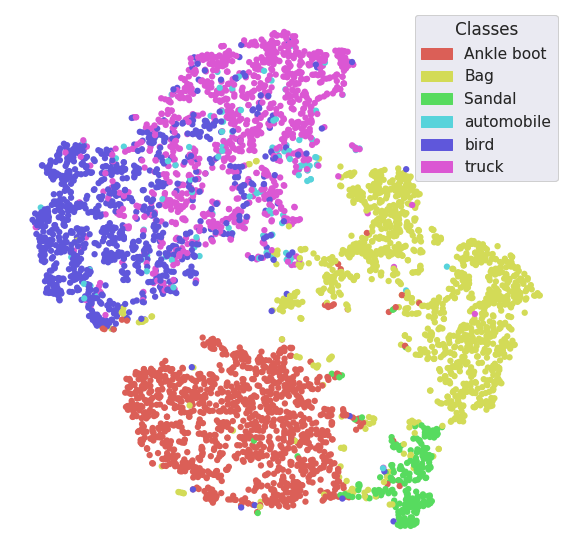

In [0]:
gray_tsne_fig = plot_tsne(gray_tsne,gray_labels,classes)

In [0]:
gray_tsne_fig[0].savefig('gray_tsne.png')

**RGB**

In [0]:
rgb_tsne,rgb_labels = get_tSNE(rgb_custom_model,rgb_val_gen)

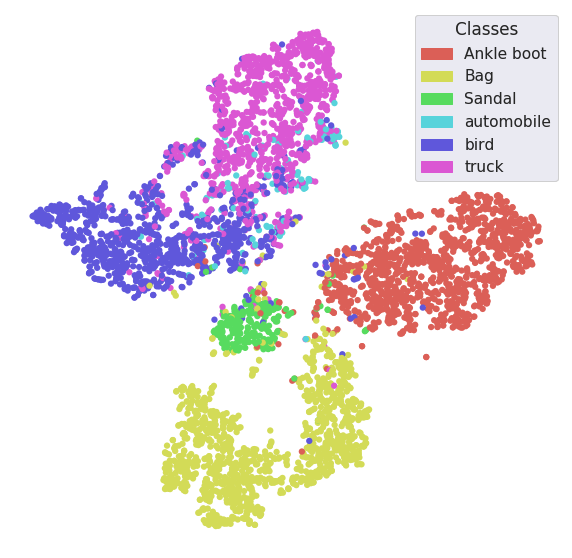

In [0]:
rgb_tsne_fig = plot_tsne(rgb_tsne,rgb_labels,classes)

In [0]:
rgb_tsne_fig[0].savefig('rgb_tsne.png')

Both Models have somewhat learned similar features which are representative of the 6 classes excluding automobile. We observe this since the features learned are shown as clusters, with each cluster representing one class. From these two visualizations we can observe that RGB is learning slightly better features since the intra-cluster distances are lower, meaning that features of same classes are similar. Another interesting observation in these plots is that our model also knows the difference between RGB images and Grayscale images. This can be seen as Ankle Boot, Sandal, and Bag class clusters are closer together and the other 3 RGB classes likewise. There is a clear seperation between these two types of images.

### Final Verdict
We have extensively analysed our models, and we will select the RGB custom model as the best approach from our experiments. This decision has been backed by the above analysis. One reason why this is so, could be because RGB images have more information than that Grayscale images, this allows our model to differenciate more easily between the RGB classes and between RGB and Grayscale classes. However, it is more confused between the RGB images as well, and that could be because these RGB are not "HD" so our model cannot detect the high-level features needed to differentiate between complex objects like Trucks, birds, automobile etc.

<br>

**Future experiments:** 
<br>
We can extend our scope of experiments and try the following approaches in the hopes of better performance:

1. Augment under-represented classes separetly and add those files to our dataset.
2. Train a deeper model, like VGG16 from scratch.
3. Try a siamese network: Siamese networks are known for learning with few samples since the focus is on the learned embeddings, a siamese network with double-margin contrastive loss or a triplet-loss may give better performance

Due to a time constraint, I was not able to perform two important tasks that I would've liked to.

1. For an extensive hyperparameter-tuning using scikit-learn's KerasClassifier wrapper and GridSearchCV/RandomizedSearchCV and pass in ranges of hyperparameters.
2. Train the model over the entire dataset available, i.e. training + validation data. Once the model has been finalised then it is important not to lose out on data and we need to train the model over validation+training data once we have selected a model.

The predict function below can be used to predict on a test set which is in a JSON file just like the one provided. In case you want it modified to match your input, please let me know I will edit it again

In [0]:
rgb_custom_opt = Adam(learning_rate=0.001,beta_1=0.5)
rgb_model = classification_model(RGB_IMG_SHAPE,rgb_custom_opt,num_classes=NUM_CLASSES)
rgb_weights_path = "rgb_weights.hdf5"
rgb_model.load_weights(rgb_weights_path)

In [0]:
def predict(path_to_json,model,input_shape=(32,32,3)):
  """
    path_to_json - full path to a json object containing test images in the same format as train images
    model - selected model loaded with pre-trained weights
  """
  json_object = read_json(path_to_json)
  classes,images = parse_json(json_object)
  labels_dict = {k:v for v,k in enumerate(list(sorted(set(classes))))}
  labels = onehot_encode(classes,labels_dict)
  test_gen = get_generators(images,labels,test=True)
  predictions = model.predict(test_gen,batch_size=BATCH_SIZE)
  y_pred = np.argmax(predictions,axis=1)
  y_true = np.argmax(test_gen.y,axis=1)
  return y_pred,y_true

# Text Classification - Predicting Star and Gender of Authors

In [6]:
import xml.etree.ElementTree as ET
import lxml
from bs4 import BeautifulSoup as bs
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Parsing Data

We have been provided with XML files where each XML file represents a single entity. Each XML file contains the 'post' and 'date' tags which contain the text for the blog post and the date it was posted respectively. 

There were two possibilities in terms of parsing the blog posts:

1. Concatenate all blog posts into one big blog post
2. Treat each blog post as a single data point and repeat the labels of the original file.

We have decided to opt for option 2, the reason is that in concatenating all blog posts, probably the first post will be retained once we crop the post to match our maximum sequence length. This option will still be suited for the problem, as the labels will be replicated.

In [0]:
blogs = glob(base_dir+'blogs_train/*')

In [0]:
def parse_xml(xml_path):
    posts = []
    dates = []
    tags = []
    # Read the XML file
    with open(xml_path, "r") as file:
        # Read each line in the file, readlines() returns a list of lines
        content = file.readlines()
        # Combine the lines in the list into a string
        content = "".join(content)
        bs_content = bs(content, "lxml")
        posts = [e.text for e in bs_content.find_all('post')]
        dates = [e.text for e in bs_content.find_all('date')]
        tags = xml_path.split('/')[-1].split('.')[1:-1]
        return tags,posts,dates

The above functon will parse a single XML file and return its posts,dates, and categorical information (tags). The function below will then use <code>parse_xml</code> to parse all files into a single list of lists. Note that there is a try/catch block. This is to prevent the function from crashing when/if it encounters errors reading/parsing a file.

In [0]:
def parse_files(blogs):
    data = []
    err = 0
    for blog in blogs:
        try:
            tags,posts,dates= parse_xml(blog)
            if (len(posts) or len(dates)):
                x = []
                for p,d in zip(posts,dates):
                    x.append([blog,tags,p,d])
                data.extend(x)
        except:
            err+=1
    print(err, " files could not be parsed out of ", len(blogs))
    return data

In [0]:
data = parse_files(blogs)

586  files could not be parsed out of  14600


As shown in the output, 586/14600 files could not be parsed. The error was due to a I/O error while reading the XML files probably because they are corrupted. Since this is a relatively small propotion, I find it safe to discard these files

We will parse the data from XML files to a single pandas DataFrame, since I find DataFrames really convenient to work with. All further processing will be done on this dataframe 

In [0]:
df = pd.DataFrame(data,columns=['path','tags','post','date'])

In [0]:
df.head()

,path,tags,post,date
0,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n YaY! i went to the races ...,"31,August,2003"
1,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n oh yeah i forgot to menti...,"29,August,2003"
2,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n YaY! today is wonderful b...,"28,August,2003"
3,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n yep ok well let me see......,"28,August,2003"
4,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n ok so i got out of school...,"27,August,2003"


As a precautionary first step, I will drop any nan values that may be encountered in the dataframe. Due to a time constraint, I am unable to go deep and find the missing values and replace them with appropriate values (By replacing them with mean/median values, or add a missing tag column)

In [0]:
df = df.dropna()

### Cleaning, Exploring Data and Feature Engineering

We will start off by splitting the tags column and adding the categories in their own respective columns.

In [0]:
def split_tags(df):
    df['gender'] = df['tags'].apply(lambda x: x[0])
    df['age'] = df['tags'].apply(lambda x: x[1])
    df['category'] = df['tags'].apply(lambda x: x[2])
    df['star'] = df['tags'].apply(lambda x: x[3])
    return df

In [0]:
df = split_tags(df)
df.head()

,path,tags,post,date,gender,age,category,star
0,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n YaY! i went to the races ...,"31,August,2003",female,17,Student,Gemini
1,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n oh yeah i forgot to menti...,"29,August,2003",female,17,Student,Gemini
2,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n YaY! today is wonderful b...,"28,August,2003",female,17,Student,Gemini
3,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n yep ok well let me see......,"28,August,2003",female,17,Student,Gemini
4,blogs_train/1835882.female.17.Student.Gemini.xml,"[female, 17, Student, Gemini]",\n\n\n \n ok so i got out of school...,"27,August,2003",female,17,Student,Gemini


Reordering columns

In [0]:
parsed_df = df[['path','post','category','age','gender','star','date']].copy()

In [0]:
parsed_df.head()

,path,post,category,age,gender,star,date
0,blogs_train/1835882.female.17.Student.Gemini.xml,\n\n\n \n YaY! i went to the races ...,Student,17,female,Gemini,"31,August,2003"
1,blogs_train/1835882.female.17.Student.Gemini.xml,\n\n\n \n oh yeah i forgot to menti...,Student,17,female,Gemini,"29,August,2003"
2,blogs_train/1835882.female.17.Student.Gemini.xml,\n\n\n \n YaY! today is wonderful b...,Student,17,female,Gemini,"28,August,2003"
3,blogs_train/1835882.female.17.Student.Gemini.xml,\n\n\n \n yep ok well let me see......,Student,17,female,Gemini,"28,August,2003"
4,blogs_train/1835882.female.17.Student.Gemini.xml,\n\n\n \n ok so i got out of school...,Student,17,female,Gemini,"27,August,2003"


The following functions will be used to clean the text. Since these are informal blog posts, there will be a lot of inconsistencies. We will remove some of these which are mentioned in the commments of the <code>clean_text</code> function. A useful pre-processing method of normalization is being skipped due to lack of time. But through normalization we can standardize a lot of slang words like "wasup", "doin", etc. in order to create better embeddings and vocabulary. This will however rqeuire deep analysis of the text.

In [0]:
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

In [0]:
def clean_text(text):
    ## Remove leading/trailing spaces
    text = text.strip()
    ## Remove stopwords
    for stopword in STOPWORDS:
        token = ' ' + stopword + ' '
        text = text.replace(token,' ')
    ## Remove any html/xml tag
    text = remove_tags(text)
    ## Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    ## Remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    ## Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    ## lower case
    text = text.lower()
    return text

In [0]:
parsed_df['post'] = parsed_df['post'].apply(clean_text)

In [0]:
parsed_df = parsed_df[['path','post','category','age','gender','star','date']]

In [0]:
parsed_df = parsed_df.dropna()

In [0]:
parsed_df.head()

,path,post,category,age,gender,star,date
0,blogs_train/1835882.female.17.Student.Gemini.xml,yay went races last nite dad awesome skip ok n...,Student,17,female,Gemini,"31,August,2003"
1,blogs_train/1835882.female.17.Student.Gemini.xml,oh yeah forgot mention whole thing madonna suc...,Student,17,female,Gemini,"29,August,2003"
2,blogs_train/1835882.female.17.Student.Gemini.xml,yay today wonderful c reasons friday day weeke...,Student,17,female,Gemini,"28,August,2003"
3,blogs_train/1835882.female.17.Student.Gemini.xml,yep ok well let see today got school early sar...,Student,17,female,Gemini,"28,August,2003"
4,blogs_train/1835882.female.17.Student.Gemini.xml,ok got school early cuz heat got home mom home...,Student,17,female,Gemini,"27,August,2003"


We have removed extra spaces, stop words, punctations, numbers (since they do not add valuable meaning to sentences) and converted text to lower case for a compact vocabulary.

In [0]:
parsed_df['post'].iloc[0]

'yay went races last nite dad awesome skip ok new car running fast fast enough beat colin northway but thats ok still really good opinion then dad went pits saw skip looked car lol bought another shirt time b skip sign yeah pits asked dad could party people said no even went grandstand dad let get stickers put car got two them sprintcar one thats says im girl dad warned about whole bunch really cute sayings one wanted get said my dad faster dad reall cute little things like that colin nothway billy alley won really super fast racers beginners too last nite last nite sprintcar racing knoxville season wait til april grrr skip going austrailia race like normally does or well going havent heard going ask could one urllink tearoffs sign never c would odd think tearoffs cool hehehe yeah know im strange neat ok well ima gonna go eat something '

In [0]:
parsed_df['post'].iloc[2000]

'hey wazup got done playing favorite game tibia got killed went lvl back got yesterday lol well um much goin today went cousins played tennis pretty fun other much my dad let put winmx back in d songs month downloaded muse time running lil wayne encore freestyle nirvana lithium big tymers no love anyway guess m going go play xbox m gonna keep tellin ya go urllink www xboximpact com later haze '

The two posts shown above show how informal they are in terms of the words used. This indicates that the problem is very complex since the same words could be rewritten in various ways by various users (Which may in turn give information, e.g. males may transform words in one way and females other). Another observation is the "urllink" word. This represents an external link posted in the forum. This can be treated as additional information as number of references people make in their blogs. Let's explore this possibility

In [0]:
parsed_df['num_references'] = parsed_df['post'].apply(lambda x: x.count("urllink"))

In [0]:
parsed_df.head()

,path,post,category,age,gender,star,date,num_references
0,blogs_train/1835882.female.17.Student.Gemini.xml,yay went races last nite dad awesome skip ok n...,Student,17,female,Gemini,"31,August,2003",1
1,blogs_train/1835882.female.17.Student.Gemini.xml,oh yeah forgot mention whole thing madonna suc...,Student,17,female,Gemini,"29,August,2003",0
2,blogs_train/1835882.female.17.Student.Gemini.xml,yay today wonderful c reasons friday day weeke...,Student,17,female,Gemini,"28,August,2003",0
3,blogs_train/1835882.female.17.Student.Gemini.xml,yep ok well let see today got school early sar...,Student,17,female,Gemini,"28,August,2003",0
4,blogs_train/1835882.female.17.Student.Gemini.xml,ok got school early cuz heat got home mom home...,Student,17,female,Gemini,"27,August,2003",0


In [0]:
parsed_df['num_references'].describe()

count    455365.000000
mean          0.550714
std           2.064614
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         694.000000
Name: num_references, dtype: float64

Most people post a single reference or none at all. So this feature may not be that helpful. The maximum value is however interesting, let's view this outlier post.

In [0]:
outlier = parsed_df[parsed_df['num_references'] == 694]
outlier

,path,post,category,age,gender,star,date,num_references
137840,blogs_train/3734683.female.27.indUnk.Gemini.xml,art urllink flowers com urllink love words url...,indUnk,27,female,Gemini,"09,August,2004",694


In [0]:
outlier['post'].iloc[0]

'art urllink flowers com urllink love words urllink bella gallery urllink novel writing software newnovelist write book urllink san francisco museum modern art urllink xchannel urllink coolmack design urllink urllink bank urllink urllink ing ing taiwan asset managment center urllink urllink urllink urllink urllink urllink fubon bank urllink book urllink countrybookshop over million books magazine subscriptions gifts more urllink http www page book com images storebig jpg urllink uk shopping directory uk shops books urllink welcome page one your independent internet bookstore urllink print urllink urllink urllink hipage urllink how many urllink how many urllink http edu seed net tw asp prodtype aspm id prodtype pt mastercategory car urllink citylife church urllink british israel church god urllink http www oursweb net search redir aspsid c b e b urllink jlovem urllink sermonaudio com james christian publishing urllink sermonaudio com web radio urllink the four spiritual laws in language

The post does not seem to make sense and looks like a spam/ad post. I would like to remove this outlier, but before doing that let's check if Female Geminis have higher number of links in their posts.

In [0]:
female_geminis = parsed_df[(parsed_df['star'] == 'Gemini') & (parsed_df['gender'] == 'female')]

In [0]:
(len(female_geminis) / len(parsed_df)) * 100

3.615341539204814

In [0]:
female_geminis['num_references'].describe()

count    16463.000000
mean         0.574561
std          5.631909
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        694.000000
Name: num_references, dtype: float64

Female Geminis are low in propotion in our dataset, but I will still remove the post since Female Geminis don't post that many links and this clearly is a spam post.

In [0]:
parsed_df = parsed_df.drop(outlier.index)

In [0]:
parsed_df['num_references'].describe()

count    455364.000000
mean          0.549191
std           1.790703
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         242.000000
Name: num_references, dtype: float64

In [0]:
outlier = parsed_df[parsed_df['num_references'] == 242]
outlier

,path,post,category,age,gender,star,date,num_references
416870,blogs_train/3667467.male.24.Student.Taurus.xml,cd green day warning found research though int...,Student,24,male,Taurus,"12,March,2003",242


Repeated the same process for the second outlier, but this seems like an actual person so will not remove this post.

In [0]:
outlier['post'].iloc[0]

'cd green day warning found research though interesting some things never change republican advocate c miller batavia ny fri evening august vol no pg col opinion today editorials agree july urllink last night cleaned part garage clear band rehearsal space this actually day before started much building inaccessible urllink july urllink before entrance sink mystery urllink july urllink this cream separator used small dairy farms saw similar one museum dated urllink july urllink later found twelve hubcaps ten spare tires urllink july urllink wrote nd th grade proving ve trying clean house since late eighties urllink july urllink the underside sink crushed weight garbage rot urllink july urllink hope read that hindsight hilarious urllink july urllink can find coffee urns picture there one brown box too by end night d found ten urllink july urllink bought dust masks last two attempts garage made sick it worked got uncomfortable hours urllink july urllink this one three refridgerators it lon

In [0]:
parsed_df['post_length'] = parsed_df['post'].apply(lambda x: len(x.split()))
parsed_df['post_length'].describe()

count    455364.000000
mean        121.515017
std         302.140095
min           0.000000
25%          26.000000
50%          71.000000
75%         153.000000
max       77315.000000
Name: post_length, dtype: float64

In [0]:
len(parsed_df)

455364

Posts of length 0 seem to be problematic since they won't be adding information regarding a person. We will filter out posts that are below say a length of 10 words (Assuming that in 10 words we can get some meaning out of a post). We will also set the maximum sequence length to ~200-256 since that will cover more that 75% of our data.

In [0]:
parsed_df = parsed_df[parsed_df['post_length'] > 10]

In [0]:
len(parsed_df)

399719

About 55,000 posts have been filtered out! That's a pretty higher number. We will filter out these posts since we need textual data for our models.

We have information about age available in our dataset. We will explore the distribution of ages and see if we can get some useful representative information out of the age label.

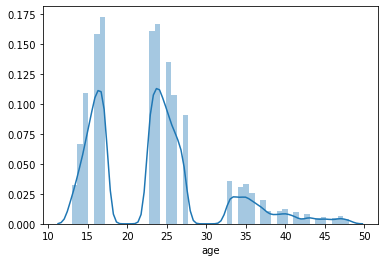

In [0]:
sns.distplot(parsed_df['age'])

From the distribution plot, we can clearly see that there are 3 age groups. We will categorize them as Teens, Adults, and Elderly (It is a bit harsh to call 30+ year old people as elders though).

In [0]:
def get_age_group(age):
    if int(age) < 20:
        return 'teen'
    elif int(age) < 30:
        return 'adult'
    else:
        return 'elderly'

In [0]:
parsed_df['age_group'] = parsed_df['age'].apply(get_age_group)

In [0]:
parsed_df.head()

,path,post,category,age,gender,star,date,num_references,post_length,age_group
0,blogs_train/1835882.female.17.Student.Gemini.xml,yay went races last nite dad awesome skip ok n...,Student,17,female,Gemini,"31,August,2003",1,152,teen
1,blogs_train/1835882.female.17.Student.Gemini.xml,oh yeah forgot mention whole thing madonna suc...,Student,17,female,Gemini,"29,August,2003",0,26,teen
2,blogs_train/1835882.female.17.Student.Gemini.xml,yay today wonderful c reasons friday day weeke...,Student,17,female,Gemini,"28,August,2003",0,45,teen
3,blogs_train/1835882.female.17.Student.Gemini.xml,yep ok well let see today got school early sar...,Student,17,female,Gemini,"28,August,2003",0,41,teen
4,blogs_train/1835882.female.17.Student.Gemini.xml,ok got school early cuz heat got home mom home...,Student,17,female,Gemini,"27,August,2003",0,51,teen


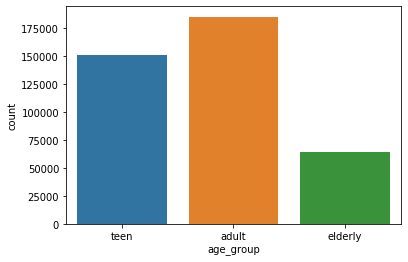

In [0]:
sns.countplot(parsed_df['age_group'])

Most posts are from adults, followed by teens and then the elderly post a lot less frequently than their counterparts.

Next up, we have categories which seem to suggest that they represent the industry or profession of the author.

In [0]:
parsed_df['category'].value_counts()

indUnk                     139558
Student                     98090
Technology                  21360
Education                   19746
Arts                        19266
Communications-Media        12446
Non-Profit                   8484
Internet                     8360
Engineering                  7718
Government                   5159
Science                      4412
Law                          4240
Consulting                   4169
Religion                     3461
Publishing                   3123
Marketing                    3029
Chemicals                    2934
BusinessServices             2844
Banking                      2693
Advertising                  2542
Fashion                      2386
Telecommunications           2285
Sports-Recreation            2278
Military                     2132
HumanResources               1908
Transportation               1644
Accounting                   1521
Biotech                      1421
Tourism                      1416
RealEstate    

We have a very diverse set of authors, with most belonging to an unknown industry. This feature can add valuable information to our data for our models

Now, we will explore the labels that we have to predict. We have been asked to predict the Astrological Star of an author based on their posts. Let's explore how our authors are distributed.

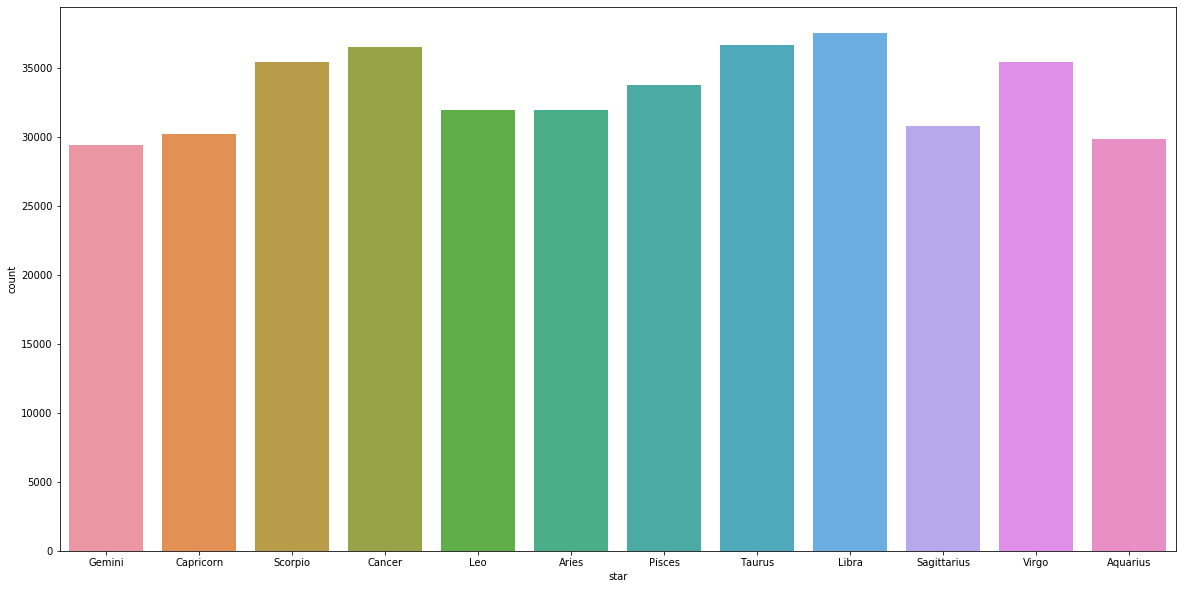

In [0]:
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(parsed_df['star'],ax=ax)

All classes of stars are almost evenly distributed. This may not be exactly representative of the actual data since one author may have more posts than the other, but it won't affect the problem of predicting a class based on the posts.

The next independant variable is the gender of the author. This is also almost evenly distirbuted. For both of these we don't necessarily need class weights (Although it never hurts to add weights)

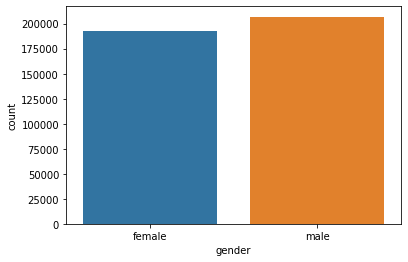

In [0]:
sns.countplot(parsed_df['gender'])

Next, we will encode all categories will integar labels, so we can use these features in our models

In [0]:
# parsed_df['star_label'] = parsed_df['star'].apply(lambda x: star_str2int[x])
# parsed_df['gender_label'] = parsed_df['gender'].apply(lambda x: gender_str2int[x])
# parsed_df['cat_label'] = parsed_df['category'].apply(lambda x: cat_str2int[x])
# parsed_df['agegroup_label'] = parsed_df['age_group'].apply(lambda x: age_str2int[x])

In [0]:
# parsed_df.to_csv('parsed_df.csv',index=False)

In [0]:
parsed_df.head()

,path,post,category,age,gender,star,date,num_references,post_length,age_group,star_label,gender_label,cat_label,agegroup_label
0,blogs_train/1835882.female.17.Student.Gemini.xml,yay went races last nite dad awesome skip ok n...,Student,17,female,Gemini,"31,August,2003",1,152,teen,4,1,34,2
1,blogs_train/1835882.female.17.Student.Gemini.xml,oh yeah forgot mention whole thing madonna suc...,Student,17,female,Gemini,"29,August,2003",0,26,teen,4,1,34,2
2,blogs_train/1835882.female.17.Student.Gemini.xml,yay today wonderful c reasons friday day weeke...,Student,17,female,Gemini,"28,August,2003",0,45,teen,4,1,34,2
3,blogs_train/1835882.female.17.Student.Gemini.xml,yep ok well let see today got school early sar...,Student,17,female,Gemini,"28,August,2003",0,41,teen,4,1,34,2
4,blogs_train/1835882.female.17.Student.Gemini.xml,ok got school early cuz heat got home mom home...,Student,17,female,Gemini,"27,August,2003",0,51,teen,4,1,34,2


In [0]:
parsed_df = pd.read_csv(base_dir+'parsed_df.csv')
stars = sorted(parsed_df['star'].unique())
star_str2int = {k:v for v,k in enumerate(stars)}
star_int2str = {k:v for v,k in star_str2int.items()}
gender_str2int = {'male' : 0, 'female': 1}
gender_int2str = {0 : 'male', 1 : 'female'}
categories = sorted(parsed_df['category'].unique())
age_groups = sorted(parsed_df['age_group'].unique())
cat_str2int = {k:v for v,k in enumerate(categories)}
age_str2int = {k:v for v,k in enumerate(age_groups)}

In [0]:
# parsed_df.to_csv(base_dir+"parsed_df.csv",index=False)

The dataset is now parsed, but the features engineered are not exhaustive. We can further explore the datset more in order to engineer more features. That is a domain in itself and we will not go too deep in it due to time constraints.

Now that the final dataset is parsed. We will create Train and validation sets that will be used throughout. 

In [0]:
train_df,val_df = train_test_split(parsed_df,test_size=0.2,random_state=SEED)

We will also very quickly skim over the split and make sure that the split has maintained the data distribution in both the training and validation sets.

In [0]:
len(train_df)

319775

In [0]:
train_df['star'].value_counts()

Libra          29995
Taurus         29391
Cancer         29254
Scorpio        28462
Virgo          28329
Pisces         27003
Leo            25690
Aries          25468
Sagittarius    24756
Capricorn      24215
Aquarius       23809
Gemini         23403
Name: star, dtype: int64

In [0]:
train_df['gender'].value_counts()

male      165685
female    154090
Name: gender, dtype: int64

In [0]:
len(val_df)

79944

In [0]:
val_df['star'].value_counts()

Libra          7549
Taurus         7309
Cancer         7282
Virgo          7154
Scorpio        6978
Pisces         6756
Aries          6481
Leo            6298
Sagittarius    6051
Gemini         6039
Aquarius       6031
Capricorn      6016
Name: star, dtype: int64

In [0]:
val_df['gender'].value_counts()

male      41225
female    38719
Name: gender, dtype: int64

Pre-processing data for model

In [0]:
parsed_df['post_length'].describe()

count    399719.000000
mean        137.659531
std         319.159741
min          11.000000
25%          40.000000
50%          86.000000
75%         168.000000
max       77315.000000
Name: post_length, dtype: float64

Before we move on to Model design, I would very quickly like to explore words we will be dealing with in order to guage the complexity of the problem at hand.

In [0]:
words = [post.split() for post in parsed_df['post'].tolist()]

In [0]:
unique_words = set([word for sublist in words for word in sublist])

In [0]:
unique_words = [word for word in unique_words if len(word) > 3]

In [0]:
len(unique_words)

486348

In [0]:
unique_words[100:200]

['yamada',
 'jetstream',
 'aehheh',
 'waqueela',
 'stoppit',
 'gezeichnet',
 'raynard',
 'dayhoff',
 'chimeny',
 'kucinnich',
 'fontus',
 'mightve',
 'jawaabay',
 'indiands',
 'threatinging',
 'sajid',
 'kisserz',
 'yaaaaaaaaaaaaayyyyyyyyyyyy',
 'bahelorette',
 'dikens',
 'evedence',
 'orinject',
 'shitstopper',
 'shll',
 'nakakita',
 'corita',
 'hilfiker',
 'berkerja',
 'tangles',
 'shanno',
 'salva',
 'entie',
 'icbms',
 'supersaver',
 'wilusa',
 'bishtare',
 'wazzu',
 'nightcreep',
 'outhit',
 'pythagorian',
 'coates',
 'yahoofs',
 'caughty',
 'chrismakkuh',
 'tennant',
 'gremlnet',
 'dorthy',
 'devics',
 'guuuuuuuuuuud',
 'ahram',
 'extincted',
 'timo',
 'ketangkep',
 'waithey',
 'eldieme',
 'cleen',
 'mamposlar',
 'cinsorium',
 'lestaluhu',
 'stooked',
 'elane',
 'standart',
 'walkes',
 'kooshinator',
 'alrerady',
 'ffree',
 'chaitra',
 'roloson',
 'jusitn',
 'unconsevable',
 'lalagnatin',
 'tessaro',
 'disjoint',
 'climbn',
 'qabanji',
 'paarkiraen',
 'salaamz',
 'reya',
 'weateh

From the above tiny sample we can observe that the number of unique words have incredibly high variance. Some of these words may be redundant, due to different writing styles, some may be names, but this all points towards the fact that the textual data is very complex in nature.

### Model Design and Selection

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, concatenate, Conv1D, GlobalMaxPooling1D, Flatten, Reshape

In [0]:
NUM_CATEGORY = len(categories)
NUM_AGE_GROUP = 3
NUM_STARS = len(stars)
BATCH_SIZE = 16
VOCAB_SIZE = 4096
EPOCHS = 10
max_length = 200
embedding_dim = 64
truncation = 'post'
padding = 'post'
oov_token = "<OOV>"

Although we have a very high number of unique words, we will limit our vocabulary to 4096 words due to memory constraints. We will also use the Tokenizer provided by the Keras API for pre-processing for our LSTM models

In [0]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE,oov_token=oov_token)
tokenizer.fit_on_texts(parsed_df['post'].tolist())

In [0]:
word_index = tokenizer.word_index

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

This is a custom generic data generator which will be used to train our models. We cannot load the entire dataset into memory so we will yield it in batches to perserve memory.

In [0]:
def data_generator(df,tokenizer=None,batch_size=16,add_post=True,tfid=False):
    total_size = len(df)
    indices = np.arange(0, total_size, batch_size)
    while True:
        np.random.shuffle(indices)
        if total_size % batch_size:
          indices = indices[:-1]
        for i,index in enumerate(indices):
            batch = df.iloc[index:index+batch_size]
            # Create datasets (Only take up to MAX_SEQ_LEN words for memory)
            texts = batch['post'].tolist()
            age_groups = to_categorical(batch['agegroup_label'].tolist(),num_classes=NUM_AGE_GROUP)
            categories = to_categorical(batch['cat_label'].tolist(),num_classes=NUM_CATEGORY)
            star_label = np.array(batch['star_label'].tolist())
            gender_label = np.array(batch['gender_label'].tolist())
            
            if add_post:
                if tfid:
                    tfids = np.array(tokenizer.transform(texts).todense().tolist())
                    yield [categories,age_groups,tfids],[star_label,gender_label]
                else:
                    sequences = tokenizer.texts_to_sequences(texts)
                    padded = pad_sequences(sequences,maxlen=max_length,padding=padding,truncating=truncation)
                    yield [categories,age_groups,padded],[star_label,gender_label]
            else:
                yield [categories,age_groups],[star_label,gender_label]

The first model that I will experiment with will be a simple Bidirectional LSTM model which will use pre-trained GloVe embeddings. The motivation for this structure is as follows:

1. Using LSTM: We could have used a vanilla RNN or GRUs for this task, but my first choice was for LSTM since they perserve contextual information of the past and help with the vanishing gradient problem occured as well.

2. Using BiLSTM: The LSTM layer is wrapped around a Bidirectional layer since this accounts for information in the past and the future and perserves more and probably better contextual information.

3. Dropouts: LSTM are known to overfit sequence data, and to counter that problem we will introduce dropout and reccurent dropout. Dropout in LSTM will add dropout on the inputs/outputs of the LSTM layer and recurrent dropout will add dropout between the recurrent units by "dropping links".

4. We also add industry information and age group of authors as one-hot encoded vectors and concatenate this with the LSTM output to add more information for our model which is processed by dense layers and the final activation layers

5. Usinge GloVe: Learning word embeddings requires a lot of compute power given the vast majority of words available. We can make use of learned embeddings over a huge corpus and use them in our models. Glove was preferred over alternatives like Word2Vec since I read that it is computationally faster. Glove is being combined with LSTMs since word embeddings alone do not capture context

**IMPORTANT**: I had originally planned to use dropout and recurrent dropout in the LSTM cell, but it turns out that they are not supported by CUDA so I had to exclude those since then the model training was taking too much time. Let's hope the other dropout layers suffice

In [0]:
# !wget "http://nlp.stanford.edu/data/glove.6B.zip"
# !unzip "glove.6B.zip"

In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = VOCAB_SIZE
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        i = 1
        for line in f:
            x = line.split()
            word,vector = x[0],x[1:]
            if word in word_index:
                # idx = word_index[word]
                if i == vocab_size:
                  break
                else:
                  embedding_matrix[i] = np.array(vector, dtype=np.float32)[:embedding_dim]
                  i+=1

    return embedding_matrix

In [0]:
emb_matrix = create_embedding_matrix(base_dir+'glove.6B.100d.txt',tokenizer.word_index,embedding_dim)

In [95]:
emb_matrix.shape

(4096, 64)

In [0]:
def lstm_model(emb_matrix):
    cat_input = Input((NUM_CATEGORY,),name="category")
    age_group_input = Input((NUM_AGE_GROUP,),name="age_group")
    post_input = Input((None,),name="post")    
    
    post_features = Embedding(VOCAB_SIZE, embedding_dim, 
                           weights=[emb_matrix], 
                           input_length=max_length, 
                           trainable=False)(post_input)
    drop = Dropout(0.2)(post_features)
    biLSTM = Bidirectional(LSTM(embedding_dim))(drop)
    concat = concatenate([cat_input,biLSTM,age_group_input])
    dense = Dense(64,activation='relu')(concat)
    drop = Dropout(0.3)(dense)
    dense = Dense(32,activation='relu')(drop)
    drop = Dropout(0.3)(dense)
    star_out = Dense(NUM_STARS,activation='softmax',name="star_prediction")(drop)
    gender_out = Dense(1,activation='sigmoid',name="gender_prediction")(drop)
    model = Model([cat_input,age_group_input,post_input],[star_out,gender_out])
    model.compile(loss=['sparse_categorical_crossentropy','binary_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model

In [0]:
lstm_classifier = lstm_model(emb_matrix)

In [0]:
# lstm_classifier.summary()

In [0]:
train_gen = data_generator(train_df,tokenizer)
val_gen = data_generator(val_df,tokenizer)

In [0]:
train_steps = len(train_df)//BATCH_SIZE
val_steps = len(val_df)//BATCH_SIZE

In [0]:
chkpt = ModelCheckpoint(base_dir+'Models/glov_lstm/weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True)
reduceLR = ReduceLROnPlateau()
callbacks = [chkpt,reduceLR]

In [110]:
lstm_hist = lstm_classifier.fit(train_gen,
                                validation_data=val_gen,
                                steps_per_epoch=train_steps,
                                validation_steps=val_steps,
                                epochs=EPOCHS,
                                callbacks=callbacks)

Epoch 1/10
19985/19985 [==============================] - 425s 21ms/step - loss: 3.0819 - star_prediction_loss: 2.4330 - gender_prediction_loss: 0.6489 - star_prediction_accuracy: 0.1372 - gender_prediction_accuracy: 0.6135 - val_loss: 3.0004 - val_star_prediction_loss: 2.3754 - val_gender_prediction_loss: 0.6250 - val_star_prediction_accuracy: 0.1709 - val_gender_prediction_accuracy: 0.6391 - lr: 0.0010
Epoch 2/10
19985/19985 [==============================] - 422s 21ms/step - loss: 3.0183 - star_prediction_loss: 2.3886 - gender_prediction_loss: 0.6297 - star_prediction_accuracy: 0.1583 - gender_prediction_accuracy: 0.6384 - val_loss: 2.9604 - val_star_prediction_loss: 2.3504 - val_gender_prediction_loss: 0.6100 - val_star_prediction_accuracy: 0.1789 - val_gender_prediction_accuracy: 0.6574 - lr: 0.0010
Epoch 3/10
19985/19985 [==============================] - 424s 21ms/step - loss: 2.9939 - star_prediction_loss: 2.3762 - gender_prediction_loss: 0.6177 - star_prediction_accuracy: 0.16

The model does not seem to overfit. We are getting a relatively higher accuracy for the gender prediction but the model performs very poorly on the star prediction problem.

Let's experiment using CNNs with glove embeddings. CNNs are very useful for feature detection, and we can use 1D convolutional layers to learn filters over the embeddings. This does not capture sequential information, but may prove to be useful especially if the problem relies on presence of certain features, e.g. words carrying similar connotation etc. The model is pretty similar to the LSTM model. We have replaced the LSTM layer with a Conv1D layer.

In [0]:
def cnn_model(emb_matrix):
    cat_input = Input((NUM_CATEGORY,),name="category")
    age_group_input = Input((NUM_AGE_GROUP,),name="age_group")
    post_input = Input((None,),name="post")
    
    post_features = Embedding(VOCAB_SIZE, embedding_dim, 
                           weights=[emb_matrix], 
                           input_length=max_length, 
                           trainable=False)(post_input)
    drop = Dropout(0.2)(post_features)
    conv = Conv1D(256,5,activation='relu')(drop)
    maxpool = GlobalMaxPooling1D()(conv)
    dense = Dense(128,activation='relu')(maxpool)
    concat = concatenate([cat_input,dense,age_group_input])
    dense = Dense(128,activation='relu')(concat)
    drop = Dropout(0.3)(dense)
    dense = Dense(64,activation='relu')(drop)
    drop = Dropout(0.3)(dense)
    star_out = Dense(NUM_STARS,activation='softmax',name="star_prediction")(drop)
    gender_out = Dense(1,activation='sigmoid',name="gender_prediction")(drop)
    model = Model([cat_input,age_group_input,post_input],[star_out,gender_out])
    model.compile(loss=['sparse_categorical_crossentropy','binary_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model

In [0]:
glove_cnn = cnn_model(emb_matrix)
train_gen = data_generator(train_df,tokenizer)
val_gen = data_generator(val_df,tokenizer)

In [0]:
chkpt = ModelCheckpoint(base_dir+'Models/glove_cnn/weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True)
reduceLR = ReduceLROnPlateau()
callbacks = [chkpt,reduceLR]

In [116]:
glove_cnn_hist = glove_cnn.fit(train_gen,
                                validation_data=val_gen,
                                steps_per_epoch=train_steps,
                                validation_steps=val_steps,
                                epochs=EPOCHS,
                                callbacks=callbacks)

Epoch 1/10
19985/19985 [==============================] - 150s 7ms/step - loss: 3.0731 - star_prediction_loss: 2.4132 - gender_prediction_loss: 0.6598 - star_prediction_accuracy: 0.1444 - gender_prediction_accuracy: 0.5948 - val_loss: 3.0264 - val_star_prediction_loss: 2.3734 - val_gender_prediction_loss: 0.6530 - val_star_prediction_accuracy: 0.1602 - val_gender_prediction_accuracy: 0.6034 - lr: 0.0010
Epoch 2/10
19985/19985 [==============================] - 150s 8ms/step - loss: 3.0439 - star_prediction_loss: 2.3874 - gender_prediction_loss: 0.6566 - star_prediction_accuracy: 0.1537 - gender_prediction_accuracy: 0.5995 - val_loss: 3.0202 - val_star_prediction_loss: 2.3676 - val_gender_prediction_loss: 0.6526 - val_star_prediction_accuracy: 0.1582 - val_gender_prediction_accuracy: 0.6043 - lr: 0.0010
Epoch 3/10
19985/19985 [==============================] - 149s 7ms/step - loss: 3.0399 - star_prediction_loss: 2.3835 - gender_prediction_loss: 0.6564 - star_prediction_accuracy: 0.1541 

This model performs worse than the LSTM model with glove embeddings. The reason maybe that the sequential information coded within the posts are important and solely detecting "features" in posts will not help solve the problem.

A potential reason for low performance maybe that the important words that represent certain entities maybe missing in the glove vocabulary. This is possible due to different kinds of slang used and different typing styles of people from different age groups. We will now use the same models and try to learn embeddings.

In [0]:
def lstm_model():
    cat_input = Input((NUM_CATEGORY,),name="category")
    age_group_input = Input((NUM_AGE_GROUP,),name="age_group")
    post_input = Input((None,),name="post")    
    
    post_features = Embedding(VOCAB_SIZE, embedding_dim,trainable=True)(post_input)
    drop = Dropout(0.2)(post_features)
    biLSTM = Bidirectional(LSTM(embedding_dim))(drop)
    concat = concatenate([cat_input,biLSTM,age_group_input])
    dense = Dense(64,activation='relu')(concat)
    drop = Dropout(0.3)(dense)
    dense = Dense(32,activation='relu')(drop)
    drop = Dropout(0.3)(dense)
    star_out = Dense(NUM_STARS,activation='softmax',name="star_prediction")(drop)
    gender_out = Dense(1,activation='sigmoid',name="gender_prediction")(drop)
    model = Model([cat_input,age_group_input,post_input],[star_out,gender_out])
    model.compile(loss=['sparse_categorical_crossentropy','binary_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model

In [0]:
lstm = lstm_model()
train_gen = data_generator(train_df,tokenizer)
val_gen = data_generator(val_df,tokenizer)

In [0]:
chkpt = ModelCheckpoint(base_dir+'Models/lstm/weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True,save_weights_only=True)
reduceLR = ReduceLROnPlateau()
callbacks = [chkpt,reduceLR]

**NOTE**: I accidently ran the training cell again last moment so it's output was refreshed. Training it for 5 epochs.

In [0]:
# lstm.save_weights(base_dir+'files/lstm_weights')

In [57]:
lstm_hist = lstm.fit(train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    epochs=5,
                    initial_epoch=4,
                    callbacks=callbacks)

Epoch 5/5
19985/19985 [==============================] - 1711s 86ms/step - loss: 2.8576 - star_prediction_loss: 2.3322 - gender_prediction_loss: 0.5254 - star_prediction_accuracy: 0.1800 - gender_prediction_accuracy: 0.7395 - val_loss: 2.8354 - val_star_prediction_loss: 2.3001 - val_gender_prediction_loss: 0.5353 - val_star_prediction_accuracy: 0.1959 - val_gender_prediction_accuracy: 0.7265 - lr: 0.0010


This model seems to perform significantly better than the LSTM and CNN models with GloVe embeddings. This also confirms that the vocabulary of our dataset is not necessarily in line with the vocabulary found in pre-trained embeddings. Learning the embeddings from scratch does show promising results, but to be sure how well it will perform, we will need to train it for a lot longer.

Even though CNN did not perform well with GloVe embeddings, for the sake of completeness, we will still explore the option of learning embeddings and then feature detection using CNNs.

In [0]:
def cnn_model():
    cat_input = Input((NUM_CATEGORY,),name="category")
    age_group_input = Input((NUM_AGE_GROUP,),name="age_group")
    post_input = Input((None,),name="post")
    
    post_features = Embedding(VOCAB_SIZE,embedding_dim)(post_input)
    drop = Dropout(0.2)(post_features)
    conv = Conv1D(256,5,activation='relu')(drop)
    maxpool = GlobalMaxPooling1D()(conv)
    dense = Dense(embedding_dim,activation='relu')(maxpool)
    concat = concatenate([cat_input,dense,age_group_input])
    dense = Dense(512,activation='relu')(concat)
    drop = Dropout(0.3)(dense)
    dense = Dense(128,activation='relu')(drop)
    drop = Dropout(0.3)(dense)
    star_out = Dense(NUM_STARS,activation='softmax',name="star_prediction")(drop)
    gender_out = Dense(1,activation='sigmoid',name="gender_prediction")(drop)
    model = Model([cat_input,age_group_input,post_input],[star_out,gender_out])
    model.compile(loss=['sparse_categorical_crossentropy','binary_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model

In [0]:
cnn = cnn_model()

In [0]:
train_gen = data_generator(train_df,tokenizer)
val_gen = data_generator(val_df,tokenizer)

In [0]:
chkpt = ModelCheckpoint(base_dir+'Models/cnn/weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True)
reduceLR = ReduceLROnPlateau()
callbacks = [chkpt,reduceLR]

In [125]:
cnn_hist = cnn.fit(train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/10
19985/19985 [==============================] - 211s 11ms/step - loss: 2.9643 - star_prediction_loss: 2.3788 - gender_prediction_loss: 0.5855 - star_prediction_accuracy: 0.1605 - gender_prediction_accuracy: 0.6891 - val_loss: 2.8981 - val_star_prediction_loss: 2.3300 - val_gender_prediction_loss: 0.5681 - val_star_prediction_accuracy: 0.1793 - val_gender_prediction_accuracy: 0.7032 - lr: 0.0010
Epoch 2/10
19985/19985 [==============================] - 208s 10ms/step - loss: 2.9038 - star_prediction_loss: 2.3438 - gender_prediction_loss: 0.5601 - star_prediction_accuracy: 0.1748 - gender_prediction_accuracy: 0.7113 - val_loss: 2.8855 - val_star_prediction_loss: 2.3223 - val_gender_prediction_loss: 0.5632 - val_star_prediction_accuracy: 0.1801 - val_gender_prediction_accuracy: 0.7036 - lr: 0.0010
Epoch 3/10
19985/19985 [==============================] - 208s 10ms/step - loss: 2.8815 - star_prediction_loss: 2.3338 - gender_prediction_loss: 0.5478 - star_prediction_accuracy: 0.17

Again, we see a considerable improvement with CNNs getting accuracies near the LSTM model. One may conclude from these experiments that learning embeddings from scratch maybe potentially be the best solution for this problem.

After these experiments containing textual data, I want to informally check if text data is adding information or is the model predicting mainly on the industry category and age_group information. To test this, I will remove textual data as input and train the model.

In [0]:
def no_text_model():
    cat_input = Input((NUM_CATEGORY,),name="category")
    age_group_input = Input((NUM_AGE_GROUP,),name="age_group")
    concat = concatenate([cat_input,age_group_input])
    dense = Dense(1024,activation='relu')(concat)
    drop = Dropout(0.3)(dense)
    dense = Dense(256,activation='relu')(drop)
    drop = Dropout(0.3)(dense)
    dense = Dense(64,activation='relu')(drop)
    drop = Dropout(0.3)(dense)
    star_out = Dense(NUM_STARS,activation='softmax',name="star_prediction")(drop)
    gender_out = Dense(1,activation='sigmoid',name="gender_prediction")(drop)
    model = Model([cat_input,age_group_input],[star_out,gender_out])
    model.compile(loss=['sparse_categorical_crossentropy','binary_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model

In [0]:
no_text_model = no_text_model()

In [0]:
train_gen = data_generator(train_df,tokenizer,add_post=False)
val_gen = data_generator(val_df,tokenizer,add_post=False)

In [0]:
chkpt = ModelCheckpoint(base_dir+'Models/no_text/weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True)
reduceLR = ReduceLROnPlateau()
callbacks = [chkpt,reduceLR]

In [130]:
no_text_hist = no_text_model.fit(train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/10
19985/19985 [==============================] - 98s 5ms/step - loss: 3.0690 - star_prediction_loss: 2.4092 - gender_prediction_loss: 0.6599 - star_prediction_accuracy: 0.1460 - gender_prediction_accuracy: 0.5957 - val_loss: 3.0268 - val_star_prediction_loss: 2.3733 - val_gender_prediction_loss: 0.6535 - val_star_prediction_accuracy: 0.1581 - val_gender_prediction_accuracy: 0.6040 - lr: 0.0010
Epoch 2/10
19985/19985 [==============================] - 97s 5ms/step - loss: 3.0471 - star_prediction_loss: 2.3898 - gender_prediction_loss: 0.6573 - star_prediction_accuracy: 0.1521 - gender_prediction_accuracy: 0.5996 - val_loss: 3.0236 - val_star_prediction_loss: 2.3710 - val_gender_prediction_loss: 0.6526 - val_star_prediction_accuracy: 0.1590 - val_gender_prediction_accuracy: 0.6040 - lr: 0.0010
Epoch 3/10
19985/19985 [==============================] - 98s 5ms/step - loss: 3.0427 - star_prediction_loss: 2.3860 - gender_prediction_loss: 0.6567 - star_prediction_accuracy: 0.1520 - g

Textual data is adding more valuable information for our model, but it is not being utilized correctly since the performance of the model using no textual data is in a comparable range compared to the models using textual data.

We have tried various methods to represent our textual data through word embeddings. Moving away from embeddings, we can move towards statistical approaches as well for instance, TF-IDF (Term Frequency-Inverse Document Frequency) which determines how important a word is in a document in a collection of documents.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Without normalization, or maybe even with normalization, the corpus of words will still be huge and the vector representation will be a very large vector which is infeasible for training. To counter this, we will select 4096 of the most important words/features (Based on their frequencies) and use those to represent a post. 4096 is by no means an optimal choice, since one can argue it is still too large for a feature vector, and one can also argue that it is too small for a corpus that contains a huge amount of words. We will nevertheless, carry forward with this setting and see how it performs.

In [0]:
vectorizer = TfidfVectorizer(max_features=4096)
vectorizer = vectorizer.fit(parsed_df['post'].tolist())

In [0]:
def save_object(obj,path):
  with open(path, 'wb') as fid:
      pickle.dump(obj, fid)

In [0]:
def load_object(path):
  with open(path, 'rb') as fid:
    return pickle.load(fid)

Saving the vectorizer for later use. (To encode test data)

In [0]:
vectorizer = load_vectorizer(base_dir+'tfidf_vectorizer.pkl')

The model for this input will be relatively simple since we will just use Dense layers that will process the TF-IDF vectors. This is because these vectors do not contain any sequential information, nor do they represent features or embeddings of words to learn kernels using CNNs.

In [0]:
def tfid_model():
    cat_input = Input((NUM_CATEGORY,),name="category")
    age_group_input = Input((NUM_AGE_GROUP,),name="age_group")
    post_input = Input((4096,),name="post")
    dense = Dense(1024,activation='relu')(post_input)
    bnorm = BatchNormalization()(dense)
    drop = Dropout(0.4)(bnorm)
    dense = Dense(512,activation='relu')(drop)
    concat = concatenate([cat_input,dense,age_group_input])
    dense = Dense(128,activation='relu')(concat)
    drop = Dropout(0.5)(dense)
    dense = Dense(64,activation='relu')(drop)
    drop = Dropout(0.5)(dense)

    star_out = Dense(NUM_STARS,activation='softmax',name="star_prediction")(drop)
    gender_out = Dense(1,activation='sigmoid',name="gender_prediction")(drop)

    model = Model([cat_input,age_group_input,post_input],[star_out,gender_out])
    model.compile(loss=['sparse_categorical_crossentropy','binary_crossentropy'],optimizer='adam',metrics=['accuracy'])

    return model

In [0]:
tfid = tfid_model()

In [0]:
chkpt = ModelCheckpoint(base_dir+'Models/tfidf/weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_best_only=True)
reduceLR = ReduceLROnPlateau()
callbacks = [chkpt,reduceLR]
# tfidf_hist = tfid_model.fit(train_gen,validation_data=val_gen,steps_per_epoch=train_steps,validation_steps=val_steps,epochs=100,callbacks=callbacks)

In [0]:
train_gen = data_generator(train_df,vectorizer,tfid=True)
val_gen = data_generator(val_df,vectorizer,tfid=True)

In [27]:
tfidf_hist = tfid.fit(train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/10
19985/19985 [==============================] - 324s 16ms/step - loss: 3.0901 - star_prediction_loss: 2.4774 - gender_prediction_loss: 0.6127 - star_prediction_accuracy: 0.0966 - gender_prediction_accuracy: 0.6668 - val_loss: 3.0299 - val_star_prediction_loss: 2.4627 - val_gender_prediction_loss: 0.5673 - val_star_prediction_accuracy: 0.1025 - val_gender_prediction_accuracy: 0.7073 - lr: 0.0010
Epoch 2/10
19985/19985 [==============================] - 322s 16ms/step - loss: 3.0309 - star_prediction_loss: 2.4652 - gender_prediction_loss: 0.5657 - star_prediction_accuracy: 0.1029 - gender_prediction_accuracy: 0.7132 - val_loss: 3.0159 - val_star_prediction_loss: 2.4560 - val_gender_prediction_loss: 0.5599 - val_star_prediction_accuracy: 0.1088 - val_gender_prediction_accuracy: 0.7168 - lr: 0.0010
Epoch 3/10
19985/19985 [==============================] - 323s 16ms/step - loss: 2.9992 - star_prediction_loss: 2.4558 - gender_prediction_loss: 0.5434 - star_prediction_accuracy: 0.11

This approach is also able to reach within comparable ranges of the best performing model, i.e. the LSTM model with learning embeddings from scratch. A drawback of this model however is that it seems to be overfitting the model after a couple of epochs as the training metrics keep improving while the validation metrics fluctuate mildly.

One last experiment that I want to conduct is to use BERT. I have not used BERT before but it has become common knowledge that BERT can be used to solve many text-related problems simply by fine-tuning it. We will see if my compute power allows to fine-tune it.

Helper functions have been adapted from : https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [0]:
# !pip install tensorflow_hub
# !pip install bert-for-tf2
# !pip install sentencepiece

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

In [0]:
max_seq_length = 256
BATCH_SIZE = 4

In [0]:
def bert_classifier(bert_layer):
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

    bert_inputs = [input_word_ids, input_mask, segment_ids]


    
    pooled_output, sequence_output = bert_layer(bert_inputs)

    dense = Dense(256,activation='relu')(pooled_output)
    cat_input = Input((NUM_CATEGORY,),name="category")
    age_group_input = Input((NUM_AGE_GROUP,),name="age_group")

    concat = concatenate([cat_input,dense,age_group_input])
    dense = Dense(128,activation='relu')(concat)
    drop = Dropout(0.3)(dense)
    dense = Dense(64,activation='relu')(drop)
    drop = Dropout(0.3)(dense)
    star_out = Dense(NUM_STARS,activation='softmax',name="star_prediction")(drop)
    gender_out = Dense(1,activation='sigmoid',name="gender_prediction")(drop)
    model = Model([cat_input,age_group_input,*bert_inputs],[star_out,gender_out])
    model.compile(loss=['sparse_categorical_crossentropy','binary_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model

In [0]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)

In [0]:
bert_model = bert_classifier(bert_layer)

In [0]:
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [0]:
def bert_generator(df,tokenizer,batch_size=16):
    total_size = len(df)
    indices = np.arange(0, total_size, batch_size)
    while True:
        np.random.shuffle(indices)
        if total_size % batch_size:
          indices = indices[:-1]
        for i,index in enumerate(indices):    
            batch = df.iloc[index:index+batch_size]
            # Create datasets (Only take up to MAX_SEQ_LEN words for memory)
            text = batch['post'].tolist()
            text = [t[0:MAX_SEQ_LEN] for t in text]
            texts = [["[CLS]"] + tokenizer.tokenize(t) + ["[SEP]"] for t in text]
            age_groups = to_categorical(batch['agegroup_label'].tolist(),num_classes=NUM_AGE_GROUP)
            categories = to_categorical(batch['cat_label'].tolist(),num_classes=NUM_CATEGORY)
            star_label = np.array(batch['star_label'].tolist())
            gender_label = np.array(batch['gender_label'].tolist())
            
            input_ids = np.array([get_ids(t, tokenizer, max_seq_length) for t in texts])
            input_masks = np.array([get_masks(t, max_seq_length) for t in texts]) 
            input_segments = np.array([get_segments(t, max_seq_length) for t in texts])
            yield [categories,age_groups,input_ids,input_masks,input_segments],[star_label,gender_label]

In [0]:
train_gen = bert_generator(train_df,tokenizer,batch_size=BATCH_SIZE)

In [38]:
bert_hist = bert_model.fit(train_gen,steps_per_epoch=len(train_df)//BATCH_SIZE,epochs=EPOCHS)

Epoch 1/10
79943/79943 [==============================] - 13785s 172ms/step - loss: 3.0753 - star_prediction_loss: 2.4143 - gender_prediction_loss: 0.6610 - star_prediction_accuracy: 0.1438 - gender_prediction_accuracy: 0.5928
Epoch 2/10
79943/79943 [==============================] - 13762s 172ms/step - loss: 3.0549 - star_prediction_loss: 2.3967 - gender_prediction_loss: 0.6582 - star_prediction_accuracy: 0.1501 - gender_prediction_accuracy: 0.5965
Epoch 3/10
11219/79943 [===>..........................] - ETA: 3:17:18 - loss: 3.0559 - star_prediction_loss: 2.3973 - gender_prediction_loss: 0.6586 - star_prediction_accuracy: 0.1484 - gender_prediction_accuracy: 0.5989

KeyboardInterrupt: ignored

I stopped the training earlier since the model using BERT is not progressing well. We have experimented with a wide range of representations for the text data, including word embeddings and TF-IDF vectors. It seems that pre-trained embeddings are not suitable for the problem at hand. After text normalization, if most of the words are standardized, then perhaps they may add value. But the way forward is to learn the embeddings.

### Analysis

In [0]:
parsed_df = pd.read_csv(base_dir+"parsed_df.csv")
train_df,val_df = train_test_split(parsed_df,test_size=0.2,random_state=SEED)
stars = sorted(parsed_df['star'].unique())
genders = ['male','female']
star_str2int = {k:v for v,k in enumerate(stars)}
star_int2str = {k:v for v,k in star_str2int.items()}
gender_str2int = {'male' : 0, 'female': 1}
gender_int2str = {0 : 'male', 1 : 'female'}
categories = sorted(parsed_df['category'].unique())
age_groups = sorted(parsed_df['age_group'].unique())
cat_str2int = {k:v for v,k in enumerate(categories)}
age_str2int = {k:v for v,k in enumerate(age_groups)}

First of all, we will create a small validation/test dataset, which we will use to analyse our models. 

In [0]:
test_df = val_df.sample(n=1024)

In [25]:
test_df['gender'].value_counts()

male      530
female    494
Name: gender, dtype: int64

In [26]:
test_df['star'].value_counts()

Pisces         98
Virgo          94
Scorpio        93
Gemini         92
Libra          89
Capricorn      87
Cancer         84
Taurus         82
Sagittarius    80
Aries          77
Aquarius       75
Leo            73
Name: star, dtype: int64

The subset extracted seems to perserve the data distribution more or less so we can use this subset to evaluate our model

In [0]:
posts = test_df['post'].tolist()
age_groups = to_categorical(test_df['agegroup_label'].tolist(),num_classes=NUM_AGE_GROUP)
categories = to_categorical(test_df['cat_label'].tolist(),num_classes=NUM_CATEGORY)
sequences = tokenizer.texts_to_sequences(posts)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding,truncating=truncation)

I am not able to perform the same comparisons performed for the image classification tasks due to runtime errors of Colab. The best model seems to be the LSTM model with learning embeddings. We will analyse it's performance on the test data created above.

In [0]:
preds = lstm.predict([categories,age_groups,padded])

In [0]:
star_preds = np.argmax(preds[0],axis=1)

In [0]:
gender_preds = preds[1]
gender_preds[gender_preds > 0.5] = 1
gender_preds[gender_preds <= 0.5] = 0

In [0]:
star_true = test_df['star_label'].tolist()
gender_true = test_df['gender_label'].tolist()

**Confusion matrix** <br>

We will evaluate our model using the confusion matrix for both the gender classification task and the star classification task.

**Star**

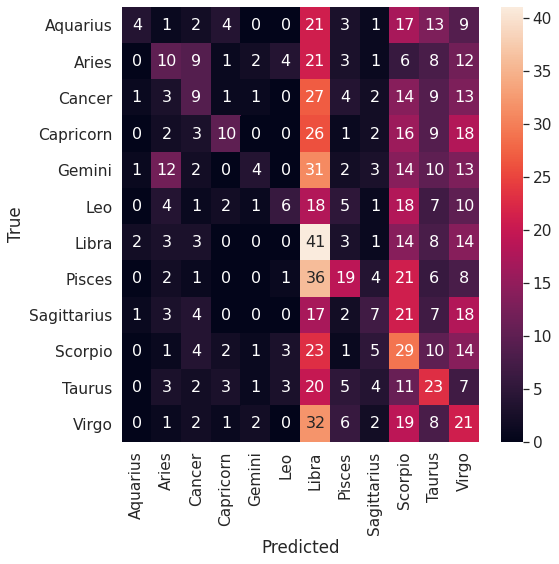

In [68]:
conf_mat = confusion_matrix(y_true=star_true,y_pred=star_preds)
star_mat = plot_confusion_matrix(conf_mat,stars)

The poor validation and training accuracy is represented here in the first glance of the confusion matrix. Scorpio, Taurus, Virgo, and Libra seem to be really problematic classes since our model is heavily confusiing these classes with other classes

In [65]:
report = classification_report(star_true,star_preds,target_names=stars)
print(report)

              precision    recall  f1-score   support

    Aquarius       0.44      0.05      0.10        75
       Aries       0.22      0.13      0.16        77
      Cancer       0.21      0.11      0.14        84
   Capricorn       0.42      0.11      0.18        87
      Gemini       0.33      0.04      0.08        92
         Leo       0.35      0.08      0.13        73
       Libra       0.13      0.46      0.20        89
      Pisces       0.35      0.19      0.25        98
 Sagittarius       0.21      0.09      0.12        80
     Scorpio       0.14      0.31      0.20        93
      Taurus       0.19      0.28      0.23        82
       Virgo       0.13      0.22      0.17        94

    accuracy                           0.18      1024
   macro avg       0.26      0.17      0.16      1024
weighted avg       0.26      0.18      0.17      1024



Recall seems to be a better measure for this case, since we want to know what propotion of true labels were correctly predicted as true. However, the recall of Libra,Scorpio,Taurus, and Virgo maybe misleading because from our confusion matrix we can see that it is mostly classifying stars between these classes. For these classes, precision is a better measure since it tells us what propotion of the predictions were actually the true stars of the authors. Overall, the model does not perform well for this classification task.

**Gender** <br>



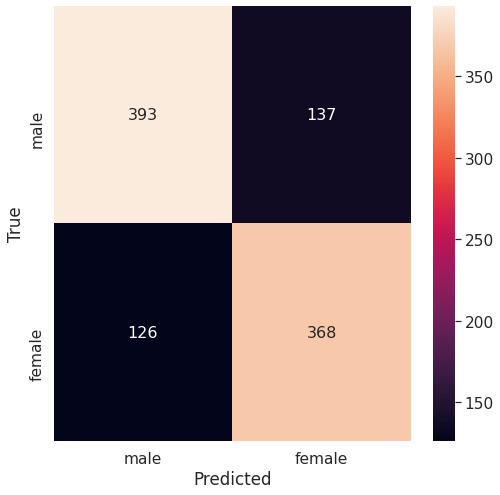

In [69]:
conf_mat = confusion_matrix(y_true=gender_true,y_pred=gender_preds)
gender_mat = plot_confusion_matrix(conf_mat,['male','female'])

Our model performs significantly better on the gender classification task, compared to the much more complex star classification task.

In [67]:
report = classification_report(gender_true,gender_preds,target_names=['male','female'])
print(report)

              precision    recall  f1-score   support

        male       0.76      0.74      0.75       530
      female       0.73      0.74      0.74       494

    accuracy                           0.74      1024
   macro avg       0.74      0.74      0.74      1024
weighted avg       0.74      0.74      0.74      1024



Precision and recall scores for both genders are close enough and a lot higher than the scores of the star classification. The model seems to be performing decently on this classification task.

### Final Verdict

The problem at hand was very complex in nature. We were provided with blog posts from authors and we had to predict the author's gender and star sign. Seeing the problem from an average human's perspective, it may seem likely that a human can guess the gender of an author based on their posts. They won't be perfect since if the posts become less informal and more formal or academic, then the problem becomes harder for humans even. Predicting the star sign of an author based on their blog posts seems almost impossible for humans even, unless the author mentions some fact about their Date of Birth or star sign directly. The same trend was observed in our models, the gender prediction accuracy was a lot higher than the star prediction accuracy.

**Future Experiments**: <br>

Although the problem is very complex in nature, it is also very interesting. The following experiments may lead to better results:

1. Extensive normalization and cleaning of blog posts: The blog post's vocabulary has a lot of variance and there's a high chance that the same words are being written differently by different authors. If we standardize these words, we can leverage pre-trained embeddings, like BERT much much better. 

2. Use punctuation with BERT and longer sequence lengths: BERT supports punctuation, and we can remove the filtering of punctuations from our cleaning function. This may provide additional context for each word and thus may give more information about the writing styles of certain authors.

3. Train stacked LSTM: We can stack LSTM cells in order to add more complexity to our models. We can use these with dropouts and recurrent dropouts so our model does not overfit the data.

4. Train the LSTM model for more epochs: Currently I was not able to train the LSTM for longer epochs due to issues with Google Colab. The model did however make progress in each epoch and there is a possibility that with more epochs the model may make more progress for the gender prediction task at least.

5. Feature Engineer complex features that have astrological significance: The star prediction task from blog posts is very complex. Even for humans it will be extremely hard to judge the star of an author. For our models to perform better, we need more features that add information that correlates with their star signs. We have been provided with dates of blog posts, we can use those dates along with the posts to get more information.

In [0]:
NUM_CATEGORY = len(categories)
NUM_AGE_GROUP = 3
NUM_STARS = len(stars)
VOCAB_SIZE = 4096
max_length = 256
truncation = 'post'
padding = 'post'
oov_token = "<OOV>"
model = lstm
model.load_weights("./lstm_weights")
tokenizer = load_object(base_dir+"tokenizer.pkl")

Our model has been trained on individual posts rather than concatenated posts of a single author. For prediction, it only makes sense to use ensemble of predictions to vote out which gender and star does the author belong to. In our prediction function, we will predict labels of all posts of a single author, and then return the final predictions based on the votes accumulated.

In [0]:
from scipy import stats

In [0]:
def preprocess_data(data):
  df = pd.DataFrame(data,columns=['path','tags','post','date'])
  df = split_tags(df)
  df['post'] = df['post'].apply(clean_text)
  df = df.dropna()
  df['post_length'] = df['post'].apply(lambda x: len(x.split()))
  df = df[df['post_length'] > 10]
  df['age_group'] = df['age'].apply(get_age_group)
  df['star_label'] = df['star'].apply(lambda x: star_str2int[x])
  df['gender_label'] = df['gender'].apply(lambda x: gender_str2int[x])
  df['cat_label'] = df['category'].apply(lambda x: cat_str2int[x])
  df['agegroup_label'] = df['age_group'].apply(lambda x: age_str2int[x])
  return df

The function below takes a dataframe containing posts from a single author. It will predict each post individually and then return the label that was most frequent.

In [0]:
def predict(df,model,tokenizer):
  texts = df['post'].tolist()
  age_groups = to_categorical(df['agegroup_label'].tolist(),num_classes=NUM_AGE_GROUP)
  categories = to_categorical(df['cat_label'].tolist(),num_classes=NUM_CATEGORY)
  sequences = tokenizer.texts_to_sequences(texts)
  padded = pad_sequences(sequences,maxlen=max_length,padding=padding,truncating=truncation)
  stars,genders = model.predict([categories,age_groups,padded])
  genders[genders > 0.5] = 1
  genders[genders <= 0.5] = 0
  stars = np.argmax(stars,axis=1)
  star = stats.mode(stars)
  gender = stats.mode(genders)
  return int(star[0].squeeze()),int(gender[0].squeeze())

In [0]:
def predict_all(file_paths,model,tokenizer):
  """
    file_paths - full paths to the XML test files,
    model - the selected model loaded with pretrained weights
    tokenizer - tokenizer used to tokenize words
  """
  data = parse_files(test_files)
  test_df = preprocess_data(data)
  test_groups = test_df.groupby('path')
  true_stars = []
  true_genders = []
  pred_stars = []
  pred_genders = []

  for path,author_df in test_groups:
    star,gender = predict(author_df,model,tokenizer)
    pred_stars.append(star)
    pred_genders.append(gender)
    true_stars.append(author_df['star'].iloc[0])
    true_genders.append(author_df['gender'].iloc[0])

  pred_stars = [stars[idx] for idx in pred_stars]
  pred_genders = [genders[idx] for idx in pred_genders]
  return pred_stars,pred_genders,true_stars,true_genders

Testing the function

In [0]:
blogs = glob(base_dir+"blogs_train/*")

In [96]:
len(blogs)

14600

In [0]:
test_files = blogs[100:105]

In [98]:
test_files

['/content/drive/My Drive/Arbisoft/blogs_train/4109616.female.26.indUnk.Aries.xml',
 '/content/drive/My Drive/Arbisoft/blogs_train/4109640.male.25.Technology.Sagittarius.xml',
 '/content/drive/My Drive/Arbisoft/blogs_train/4109680.female.25.indUnk.Scorpio.xml',
 '/content/drive/My Drive/Arbisoft/blogs_train/4109862.female.35.Advertising.Gemini.xml',
 '/content/drive/My Drive/Arbisoft/blogs_train/4109863.male.16.Student.Cancer.xml']

In [137]:
star_pred,gender_pred,star_true,gender_true = predict_all(test_files,lstm,tokenizer)

0  files could not be parsed out of  5


In [138]:
star_pred

['Libra', 'Libra', 'Scorpio', 'Aries', 'Libra']

In [113]:
star_true

['Aries', 'Sagittarius', 'Scorpio', 'Gemini', 'Cancer']

In [139]:
gender_pred

['female', 'male', 'female', 'male', 'male']

In [140]:
gender_true

['female', 'male', 'female', 'female', 'male']